# AIRBNB LOCATIONS

 ------------
## Group 04
Margarida Cruz - 20221929 \
João Capitão - 20221863 \
Luis Mendes - 20221949 \
Dinis Gaspar - 20221869

--------------------

# Summary

Data analysis is crucial to help improve decision-making in large companies such as Airbnb, as it allows for data-driven decisions which are proven to have higher success rates.\
\
In this project we seek to dive deep into Airbnb's operations in the United States by performing a wide-ranging analysis based on the characteristics of Airbnb's business across States and cities. Additionally, we will perform an analysis of the profiles of hosts on the platform. We believe these insights can help in cultivating a much better knowledge base for the decison making within the company.\
\
Furthermore, one of the greatest sources of knowledge is often found by cross-referencing information to gather multidimensional knowledge rather than linear information based on a single data source. For this reason, we will integrate different sources into our analysis, these external data sources contain information about gun crime, State population and Museums in the United States, by looking for information such as the connection between fatal gun crimes and the location and performance of Airbnbs in the surrounding areas.\
\
We believe these data sources are not only relevant towards a proper overview of Airbnb's operation but also good indicators of what the Airbnb user might consider important factors when choosing a room on the platform.\
\
Thus, we believe that through the implementation of the methods described above we can achieve a strong foundation for a data-driven decision-making process.

## Importing the necessary libraries

In [5]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, box, Polygon, LineString
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
print(pd.__version__)
print(gpd.__version__)
print(sns.__version__)

2.0.3
0.13.2
0.12.2


Versions: \
-Pandas: '2.0.3' \
-Geopandas: '0.13.2' \
-Seaborn: '0.12.2'  \
-Matplotlib: '3.7.2'

# I. Level 1: Preprocessing and Exploratory Data Analysis (EDA):

Below is a simple description of the dataset we received from AirBNB regarding its operations in the USA:

| Attribute  | Description  |
| --- | --- |
| room_id   | Airbnb's unique identifier for the listing  |
| host_id | Airbnb's unique identifier for the host/user neighbourhood Location of the listing  |
| latitude | Latitude of the listing (uses WGS84 projection) |
| longitude | Longitude of the listing (uses WGS84 projection)  |
| room_type  | Room type of the listing price Daily price of the listing in USD  |
| minimum_nights   | Minimum number of night stay |
|  total_reviews   | Total number of reviews |
|availability_365 |The availability of the listing 365 days in advance  |
| number_of_reviews_lt m   | Total number of reviews in the last 12 months  |
| state  | State of the listing (abbreviated)  |
| city   | City/County of the listing |

We will check for inconsitencies within the dataset and address any issues before proceeding with any analysis.

## Importing the airbnbs locations dataset

We started importing the dataset in chunks of 20000 observations since it was big (around 300000 observations) and them join every chunk to have the complete dataset.

In [7]:
store_chunks_list = []

# Read in the data in chunks and append to list
for chunk in pd.read_csv('airbnb_listings_usa.csv', chunksize=20000, engine= 'c'):
    store_chunks_list.append(chunk)

# Concatenate all chunks into a single DataFrame
airbnb = pd.concat(store_chunks_list)

In [8]:
airbnb.head()

,room_id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,total_reviews,availability_365,number_of_reviews_ltm,state,city
0,183319,867995,Venice,33.99211,-118.47600,Entire home/apt,152,30,3,0,0,CA,Los Angeles
1,109,521,Culver City,33.98301,-118.38607,Entire home/apt,115,30,2,139,0,CA,Los Angeles
2,51307,235568,Atwater Village,34.12206,-118.26783,Entire home/apt,75,30,138,224,0,CA,Los Angeles
3,184314,884031,Venice,33.97487,-118.46312,Entire home/apt,125,30,30,0,0,CA,Los Angeles
4,51498,236758,Mar Vista,34.00389,-118.44126,Entire home/apt,189,3,378,348,41,CA,Los Angeles


## Pre-processing

Let's check the existence of missing values, datatypes, and the space that the dataset is using.

In [9]:
airbnb.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316999 entries, 0 to 316998
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   room_id                316999 non-null  int64  
 1   host_id                316999 non-null  int64  
 2   neighbourhood          316999 non-null  object 
 3   latitude               316999 non-null  float64
 4   longitude              316999 non-null  float64
 5   room_type              316999 non-null  object 
 6   price                  316999 non-null  int64  
 7   minimum_nights         316999 non-null  int64  
 8   total_reviews          316999 non-null  int64  
 9   availability_365       316999 non-null  int64  
 10  number_of_reviews_ltm  316999 non-null  int64  
 11  state                  316999 non-null  object 
 12  city                   316999 non-null  object 
dtypes: float64(2), int64(7), object(4)
memory usage: 102.3 MB


Conclusion: no missing values in any column, we have the default datatypes and we should have 316999 unique Airbnbs.

# Let's check the existence of unique values by column.

In [10]:
airbnb.nunique()

room_id                  267410
host_id                  133432
neighbourhood              1575
latitude                 188069
longitude                190501
room_type                     4
price                      2683
minimum_nights              179
total_reviews               843
availability_365            366
number_of_reviews_ltm       293
state                        19
city                         31
dtype: int64

In [11]:
len(airbnb)

316999

There are duplicate rooms (rooms with the same id), because there are more observations than number of unique id´s, so we need to treat those duplicates.

In [12]:
# Check for duplicated rows (Complete equal rows)
duplicates_mask = airbnb.duplicated()
# Filter and display the duplicate rows
duplicate_rows = airbnb[duplicates_mask]
len(duplicate_rows)

44383

There are **44383** rows which are perfect duplicates(duplicates for all columns) of previous rows, these will be deleted. This will allow us to remove the duplicates without losing the original observations, which means that even though we are removing observations we won't lose any information.



In [13]:
airbnb.drop(duplicate_rows.index, inplace = True)
airbnb

,room_id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,total_reviews,availability_365,number_of_reviews_ltm,state,city
0,183319,867995,Venice,33.992110,-118.476000,Entire home/apt,152,30,3,0,0,CA,Los Angeles
1,109,521,Culver City,33.983010,-118.386070,Entire home/apt,115,30,2,139,0,CA,Los Angeles
2,51307,235568,Atwater Village,34.122060,-118.267830,Entire home/apt,75,30,138,224,0,CA,Los Angeles
3,184314,884031,Venice,33.974870,-118.463120,Entire home/apt,125,30,30,0,0,CA,Los Angeles
4,51498,236758,Mar Vista,34.003890,-118.441260,Entire home/apt,189,3,378,348,41,CA,Los Angeles
...,...,...,...,...,...,...,...,...,...,...,...,...,...
316994,45079266,890326,Highland Park,47.504459,-122.348915,Entire home/apt,125,3,16,0,7,WA,Seattle
316995,664956215516199232,48416955,Central Business District,47.606606,-122.341684,Entire home/apt,184,1,22,6,22,WA,Seattle
316996,49692446,268690467,South Delridge,47.513300,-122.355450,Entire home/apt,175,3,5,0,2,WA,Seattle
316997,50035217,403563664,Highland Park,47.512220,-122.328250,Entire home/apt,109,1,21,0,19,WA,Seattle


In [14]:
# Check for duplicates based on the columns room_id (only with same room_id)
duplicates_mask_room_id = airbnb.duplicated(subset=['room_id'], keep = False)
# Filter and display the duplicate rows
duplicate_room_id = airbnb[duplicates_mask_room_id]
len(duplicate_room_id)

10412

In [15]:
# Check for duplicates based on the columns room_id and city (with same room_id and same city)
duplicates_mask_room_id_city = airbnb.duplicated(subset=['room_id', 'city'], keep = False)
# Filter and display the duplicate rows
duplicate_room_id_city = airbnb[duplicates_mask_room_id_city]
len(duplicate_room_id_city)

0

With the two cells above we can understand that there are a further 10412 rows with duplicate room_id, but no duplicates for room_id and city, thus we can conclude that these 10412 duplicates have the same room_id but different cities. For this reason all observations with duplicated room_id will be deleted. In this situation, unlike with the perfect duplicates, we will also delete the original observation.

In [16]:
airbnb.drop(duplicate_room_id.index, inplace = True)
airbnb

,room_id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,total_reviews,availability_365,number_of_reviews_ltm,state,city
0,183319,867995,Venice,33.992110,-118.476000,Entire home/apt,152,30,3,0,0,CA,Los Angeles
1,109,521,Culver City,33.983010,-118.386070,Entire home/apt,115,30,2,139,0,CA,Los Angeles
2,51307,235568,Atwater Village,34.122060,-118.267830,Entire home/apt,75,30,138,224,0,CA,Los Angeles
3,184314,884031,Venice,33.974870,-118.463120,Entire home/apt,125,30,30,0,0,CA,Los Angeles
4,51498,236758,Mar Vista,34.003890,-118.441260,Entire home/apt,189,3,378,348,41,CA,Los Angeles
...,...,...,...,...,...,...,...,...,...,...,...,...,...
316994,45079266,890326,Highland Park,47.504459,-122.348915,Entire home/apt,125,3,16,0,7,WA,Seattle
316995,664956215516199232,48416955,Central Business District,47.606606,-122.341684,Entire home/apt,184,1,22,6,22,WA,Seattle
316996,49692446,268690467,South Delridge,47.513300,-122.355450,Entire home/apt,175,3,5,0,2,WA,Seattle
316997,50035217,403563664,Highland Park,47.512220,-122.328250,Entire home/apt,109,1,21,0,19,WA,Seattle


Now let’s look at some descriptive statistics associated with our dataset.

In [17]:
airbnb.nunique()

room_id                  262204
host_id                  131779
neighbourhood              1575
latitude                 184976
longitude                187230
room_type                     4
price                      2669
minimum_nights              178
total_reviews               836
availability_365            366
number_of_reviews_ltm       283
state                        19
city                         31
dtype: int64

In [18]:
print(262204/131779)

1.9897252217728165


In [19]:
airbnb[['room_type']].value_counts()

room_type      
Entire home/apt    201692
Private room        57955
Shared room          1466
Hotel room           1091
Name: count, dtype: int64

In [20]:
airbnb.describe(include=['O']).T

,count,unique,top,freq
neighbourhood,262204,1575,Unincorporated Areas,12516
room_type,262204,4,Entire home/apt,201692
state,262204,19,CA,76749
city,262204,31,Los Angeles,44383


Conclusions:

+ We had 262204 unique Airnbnbs.
+ We had hosts with multiples Airbnbs, since there are more unique rooms than unique host id´s, in more detail every host has, on average, approximately 2 Airbnbs.
+ We only had data of 1575 neighborhoods, 19 states (with California (CA) being the one that had the most information) and 31 cities (with Los Angeles the one that had the most information).
+ We had only 4 room types: Entire home/apt (with 201692 observations, the most abundant type of Airbnb), Private room (with 57955 observations), Shared room (with 1466 observations), and Hotel room (with 1091 observations, the least abundant type of Airbnb, which makes sense because Airbnb is primarily a service to rent homes/rooms and not hotel rooms).
+ The price of the Airbnbs doesn’t change much since we only have 2669 unique prices.


In [21]:
airbnb.describe().T

,count,mean,std,min,25%,50%,75%,max
room_id,262204.0,1.530996e+17,2.728830e+17,109.00000,2.396509e+07,4.511114e+07,5.416992e+07,7.251653e+17
host_id,262204.0,1.438157e+08,1.448482e+08,23.00000,2.302507e+07,9.168921e+07,2.364388e+08,4.810023e+08
latitude,262204.0,3.451315e+01,6.747610e+00,19.00275,3.037917e+01,3.416419e+01,4.066217e+01,4.774800e+01
longitude,262204.0,-1.053611e+02,2.551304e+01,-159.71462,-1.184423e+02,-1.050391e+02,-8.014908e+01,-7.091325e+01
price,262204.0,2.910965e+02,8.781567e+02,40.00000,1.000000e+02,1.610000e+02,2.760000e+02,1.000000e+05
minimum_nights,262204.0,1.220215e+01,2.773374e+01,1.00000,2.000000e+00,3.000000e+00,3.000000e+01,1.250000e+03
total_reviews,262204.0,4.037694e+01,7.618822e+01,0.00000,1.000000e+00,1.000000e+01,4.400000e+01,2.600000e+03
availability_365,262204.0,1.800881e+02,1.331666e+02,0.00000,5.300000e+01,1.720000e+02,3.190000e+02,3.650000e+02
number_of_reviews_ltm,262204.0,1.235402e+01,2.062892e+01,0.00000,0.000000e+00,3.000000e+00,1.700000e+01,1.284000e+03


In [22]:
airbnb[['host_id']].max()

host_id    481002317
dtype: int64

In [23]:
airbnb[['room_id']].max()

room_id    725165330340190849
dtype: int64

Conclusions:
+ Our room id goes from 109 to 725165330340190849.
+ Our host id goes from 23 to 481002317.
+ Price goes from 40 to 100000 (per night), the average price per night is 291 dollars, with a standard deviation of 878 dollars (a small one compared to our range). 75% of our Airbnbs cost below 276$ per night.
+ The minimum nights to stay goes from 1 to 1250 nights, the average number of nights is 12, with a standard deviation of 27 (a small one compared to our range). 50% of our Airbnbs have a minimum stay of at 3 nights or less.
+ Looking at the conclusions about prices and minimum nights, we can see that, in general, the Airbnbs are being used for their initial purpose, which is renting a home or a place for small trips at a great price for the traveler.
+ Total of reviews goes from 0 to 2600, with a mean of 4 reviews per Airbnb.
+ The number of reviews in the past 12 months goes from 0 to 1284, with around 2 reviews per Airbnb, on average, and 75% of our Airbnbs have 17 or less reviews in the past 12 months.
+ The availability 365 goes from 0 to 365, with an average of 180 days, making it possible to book the majority of the Airbnbs with half a year in advance.

Now that we have only unique Airbnbs, and the range of the numerical columns, let's transform the datatypes to clear some memory space.

In [24]:
# Converting to different datatypes
airbnb = airbnb.astype({'room_id' : 'int32',
                        'host_id' : 'int32',
                        'latitude' : 'float64',
                        'longitude' : 'float64',
                        'price' : 'int32',
                        'minimum_nights' : 'int16',
                        'total_reviews' : 'int16',
                        'availability_365' : 'int16',
                        'number_of_reviews_ltm' : 'int16',
                        'neighbourhood' : 'category',
                        'room_type' : 'category',
                        'state' : 'category',
                        'city' : 'category',
                                              })

# Checking memory usage
airbnb.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 262204 entries, 0 to 316998
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   room_id                262204 non-null  int32   
 1   host_id                262204 non-null  int32   
 2   neighbourhood          262204 non-null  category
 3   latitude               262204 non-null  float64 
 4   longitude              262204 non-null  float64 
 5   room_type              262204 non-null  category
 6   price                  262204 non-null  int32   
 7   minimum_nights         262204 non-null  int16   
 8   total_reviews          262204 non-null  int16   
 9   availability_365       262204 non-null  int16   
 10  number_of_reviews_ltm  262204 non-null  int16   
 11  state                  262204 non-null  category
 12  city                   262204 non-null  category
dtypes: category(4), float64(2), int16(4), int32(3)
memory usage: 12.4 MB


In [25]:
airbnb.head()

,room_id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,total_reviews,availability_365,number_of_reviews_ltm,state,city
0,183319,867995,Venice,33.99211,-118.47600,Entire home/apt,152,30,3,0,0,CA,Los Angeles
1,109,521,Culver City,33.98301,-118.38607,Entire home/apt,115,30,2,139,0,CA,Los Angeles
2,51307,235568,Atwater Village,34.12206,-118.26783,Entire home/apt,75,30,138,224,0,CA,Los Angeles
3,184314,884031,Venice,33.97487,-118.46312,Entire home/apt,125,30,30,0,0,CA,Los Angeles
4,51498,236758,Mar Vista,34.00389,-118.44126,Entire home/apt,189,3,378,348,41,CA,Los Angeles


Now let's estimate the geocode of our dataset, to do it we will use the complete address to see which coordinates could fit our longitude and latitude.

In [26]:
airbnb['full_address']=airbnb['state'].astype(str)+", "+airbnb['city'].astype(str)+", "+airbnb['neighbourhood'].astype(str)

find_crs = gpd.tools.geocode(airbnb['full_address'].iloc[0:20], timeout=3)
find_crs

,geometry,address
0,POINT (-118.46689 33.99504),"Venice, 90291, Los Angeles, California, United..."
1,POINT (-118.39647 34.02112),"Culver City, California, United States"
2,POINT (-118.26239 34.11870),"Atwater Village, 90039, Los Angeles, Californi..."
3,POINT (-118.46689 33.99504),"Venice, 90291, Los Angeles, California, United..."
4,POINT (-118.43916 34.00376),"Mar Vista, 90066, Los Angeles, California, Uni..."
5,POINT (-118.32952 34.09800),"Hollywood, 90028, Los Angeles, California, Uni..."
6,POINT (-118.40063 33.95973),"Westchester, 90045, Los Angeles, California, U..."
7,POINT (-118.49123 34.01947),"Santa Monica, California, United States"
8,POINT (-118.11677 33.88257),"Bellflower, 90706, California, United States"
9,POINT (-118.34658 34.12169),"Hollywood Hills, 90068, Los Angeles, Californi..."


In [27]:
find_crs.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [28]:
find_crs.estimate_utm_crs()

<Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 120°W and 114°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Alberta; British Columbia (BC); Northwest Territories (NWT); Nunavut. Mexico. United States (USA).
- bounds: (-120.0, 0.0, -114.0, 84.0)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We had a CRS EPSG: 4326 (in degrees) and EPSG: 32611 (in meters). Let's create our geometry (point) that represents the location of the Airbnbs using the longitude and latitude from the dataset and use the CRS that we found.

In [29]:
airbnb = gpd.GeoDataFrame(
    airbnb, geometry=gpd.points_from_xy(airbnb.longitude, airbnb.latitude), crs="EPSG:4326")


In [30]:
print(airbnb.geometry.name)
print()
airbnb.crs

geometry



<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [31]:
# We estimate to see if we could use the same than the one that we previously found
airbnb.estimate_utm_crs()

<Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 120°W and 114°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Alberta; British Columbia (BC); Northwest Territories (NWT); Nunavut. Mexico. United States (USA).
- bounds: (-120.0, 0.0, -114.0, 84.0)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We change the CRS to EPSG:32611 because it's in meters.

In [32]:
airbnb.to_crs(32611, inplace =True)

In [33]:
airbnb.crs

<Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 120°W and 114°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Alberta; British Columbia (BC); Northwest Territories (NWT); Nunavut. Mexico. United States (USA).
- bounds: (-120.0, 0.0, -114.0, 84.0)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Here is our Geodataframe:

In [34]:
airbnb.head()

,room_id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,total_reviews,availability_365,number_of_reviews_ltm,state,city,full_address,geometry
0,183319,867995,Venice,33.99211,-118.47600,Entire home/apt,152,30,3,0,0,CA,Los Angeles,"CA, Los Angeles, Venice",POINT (363676.299 3762262.979)
1,109,521,Culver City,33.98301,-118.38607,Entire home/apt,115,30,2,139,0,CA,Los Angeles,"CA, Los Angeles, Culver City",POINT (371969.238 3761137.864)
2,51307,235568,Atwater Village,34.12206,-118.26783,Entire home/apt,75,30,138,224,0,CA,Los Angeles,"CA, Los Angeles, Atwater Village",POINT (383082.811 3776415.587)
3,184314,884031,Venice,33.97487,-118.46312,Entire home/apt,125,30,30,0,0,CA,Los Angeles,"CA, Los Angeles, Venice",POINT (364838.704 3760334.148)
4,51498,236758,Mar Vista,34.00389,-118.44126,Entire home/apt,189,3,378,348,41,CA,Los Angeles,"CA, Los Angeles, Mar Vista",POINT (366903.531 3763523.596)


Exploring the airbnb locations

In [35]:
#airbnb.explore()

# Here is the output of all of our Airbnbs

# We have a photo because if not the notebook gets slower

<img src="Airbnb_loc.png" alt="Airbnb Locations" width="1000" height="300">

Conclusion:
+ We only have Airbnbs in the USA as we expected.
+ We have Airbnb from Hawaii, New York, Miami and in summary we have Airbnb from cities that are very far away, so if we calculate areas, they will be very large.


We will transform the state to the full name to make the interpreation of the dataset simpler.

In [36]:
# Number of Airbnb per state
airbnb['state'].value_counts()

state
CA    76749
NY    37267
HI    28487
TX    25229
FL    16366
NV    14345
TN     7636
IL     7155
LA     6838
DC     6286
WA     5858
CO     5684
RI     4802
OR     4796
MN     3957
NC     2976
MA     2906
NJ     2737
OH     2130
Name: count, dtype: int64

In [37]:
# Dictionary to map the states
dic_states = {
                'CA':'California',
                'NY':'New York',
                'HI':'Hawaii',
                'TX':'Texas',
                'FL':'Florida',
                'NV':'Nevada',
                'TN':'Tennessee',
                'IL':'Illinois',
                'LA':'Louisiana',
                'DC':'District of Columbia',
                'WA':'Washington',
                'CO':'Colorado',
                'RI':'Rhode Island',
                'OR':'Oregon',
                'MN':'Minnesota',
                'NC':'North Carolina',
                'MA':'Massachusetts',
                'NJ':'New Jersey',
                'OH':'Ohio',
            }

# Transforming the state codes into state names
airbnb['state'] = airbnb['state'].replace(dic_states)
# Checking the transformation
airbnb['state'].value_counts()

state
California              76749
New York                37267
Hawaii                  28487
Texas                   25229
Florida                 16366
Nevada                  14345
Tennessee                7636
Illinois                 7155
Louisiana                6838
District of Columbia     6286
Washington               5858
Colorado                 5684
Rhode Island             4802
Oregon                   4796
Minnesota                3957
North Carolina           2976
Massachusetts            2906
New Jersey               2737
Ohio                     2130
Name: count, dtype: int64

Now we will perform analysis of our Airbnbs by comparing information across states.

In [38]:
# Grouping by state to know more insights
analysis_airbnb_state = airbnb.groupby(['state']).agg(
    {'city':pd.Series.mode,  # Most common city
    'room_id':"count",  # Number of Airbnbs
     'host_id': pd.Series.nunique, # Number of hosts
     'price': ["mean", 'min', 'max'], # Mean, Minimum, and Maximum of price
     'minimum_nights': ["mean"], # Mean of minimum_nights
    }
).sort_values([('price', 'mean')]) # Smaller prices at the top
# To see the mean number of Airbnb per host
analysis_airbnb_state['Ratio_airbnb_host'] = analysis_airbnb_state[('room_id', 'count')].values/analysis_airbnb_state[('host_id', 'nunique')].values

analysis_airbnb_state

city room_id host_id       price              \
                                 mode   count nunique        mean min     max   
state                                                                           
Ohio                         Columbus    2130     854  159.151643  40    1268   
Colorado                       Denver    5684    3650  180.798205  40   10000   
Oregon                       Portland    4796    3320  181.713094  40    9999   
District of Columbia  Washington D.C.    6286    3501  183.505727  40   10000   
Washington                    Seattle    5858    3182  185.736770  40    3600   
New Jersey                     Newark    2737    1287  191.482645  40   99999   
New York                New York City   37267   25227  197.432098  40   16500   
Louisiana                 New Orleans    6838    3414  200.145949  40   10000   
Massachusetts                  Boston    2906    1380  202.279766  40   10000   
North Carolina              Asheville    2976    1910  217.831317  40   25000   
Illinois                      Chicago    7155    3456  218.237037  40   10000   
Florida                       Broward   16366    6985  245.349994  40  100000   
Minnesota             Twin Cities MSA    3957    2537  270.281779  40   10000   
Tennessee                   Nashville    7636    3389  291.764144  40   10500   
California                Los Angeles   76749   39231  297.032952  40  100000   
Texas                          Austin   25229   13669  340.428118  40   23000   
Rhode Island             Rhode Island    4802    2667  359.464390  40   10000   
Nevada                   Clark County   14345    5797  402.251446  40   25000   
Hawaii                         Hawaii   28487    8098  477.554499  40   26774   

                     minimum_nights Ratio_airbnb_host  
                               mean                    
state                                                  
Ohio                       6.115493          2.494145  
Colorado                  15.258973          1.557260  
Oregon                     8.210592          1.444578  
District of Columbia      21.255170          1.795487  
Washington                12.760498          1.840981  
New Jersey                10.025941          2.126651  
New York                  18.388226          1.477266  
Louisiana                  8.689383          2.002929  
Massachusetts             30.532003          2.105797  
North Carolina             5.269489          1.558115  
Illinois                  13.710552          2.070312  
Florida                    5.741721          2.343021  
Minnesota                  7.129138          1.559716  
Tennessee                  5.727213          2.253172  
California                15.195130          1.956336  
Texas                      6.802093          1.845709  
Rhode Island               5.363390          1.800525  
Nevada                     7.245870          2.474556  
Hawaii                     8.561274          3.517782

We have a Dataframe where the first column represents the state that we are analyzing, the second column the most frequent City in that state, then the number of Airbnbs in that state, after that the number of unique hosts, then we see the minimum, maximum and mean price of Airbnb per state, then the mean number of minimum nights, and finally the ratio of rooms per host for each state. \
\
Conclusions:
+ The cheapest state to stay is Ohio with mean price per night of 159,15 dollars and the most expensive one is Hawaii mean price per night of 4477,55$. All states have an Airbnb which costs 40 dollars per night. Some states (California, Florida, New Jersey) have luxury Airbnbs since the prices to stay there go up to 100000 dollars per night.
+ The state with the most Airbnbs is California (with 76749), and the one with the least is Ohio (with 2130).
+ The state with the most hosts is California (with 39231), and the one with least is Ohio (with 854).
+ The state with more Airbnbs per host is Hawaii (with approximately 3,5 Airbnbs per host, on average), and the one with the least is Oregon (with 1,44 Airbnbs per host, on average).
+ The state with the lowest minimum stay, on average, is North Carolina (with an average minimum stay of 5 nights), and the state with the highest is Massachussets (with an average minimum stay of 30 nights).



Now let's visualize the price per night differences across different states by plotting them on a map.

In [39]:
#geometry_state = (gpd.GeoDataFrame(airbnb.dissolve(['state'])['geometry'])).reset_index()
#geometry_state['geometry'] = geometry_state['geometry'].convex_hull.buffer(80000)
#base_price = geometry_state.explore( column='state', cmap = 'binary', legend=False)
#plot_state = (gpd.GeoDataFrame(airbnb.dissolve(['state'])['geometry'])).reset_index().merge(analysis_airbnb_state[[('price', 'mean')]].droplevel(level=1, axis=1).reset_index())
#plot_state.explore(m =base_price , column='price',cmap="Wistia",legend=True,tooltip=False)

# Here we have visualizations of the geocoded dataset
# Is in a photo because if not the notebook gets slower.

<img src="state.png" alt="state" width="1000" height="300">

Now we will analyze in the differences between one city to another.

In [40]:
# Grouping by city to know more insights
analysis_airbnb_city = airbnb.groupby(['city']).agg(
    {'state':'first',  # Number of airbnbs
    'room_id':"count",  # Number of airbnbs
     'host_id': pd.Series.nunique, # Number of hosts
     'price': ["mean", 'min', 'max'], # Mean, Minimum, and Maximum of price
     'minimum_nights': ["mean"], # Mean of minimum_nights
    }
).sort_values([('state','first'),('price', 'mean')]) # Smaller prices at the top, and states together
# To see the mean number of Airbnbs per host
analysis_airbnb_city['Ratio_airbnb_host'] = analysis_airbnb_city[('room_id', 'count')].values/analysis_airbnb_city[('host_id', 'nunique')].values

# Go one by one to print per state
for index, row in analysis_airbnb_state.iterrows():
    # Only print if there is more than one city in that state, because if there is only 1 it's the same result as the group of the state
    if len(analysis_airbnb_city[analysis_airbnb_city[('state','first')] == index]) >1:
        print(f'Cities from {index}:')
        # Display the dataframe
        display(analysis_airbnb_city[analysis_airbnb_city[('state','first')] == index])
        print()

Cities from Oregon:


state room_id host_id       price           minimum_nights  \
           first   count nunique        mean min   max           mean   
city                                                                    
Salem     Oregon     262     166  139.812977  40  1000       7.167939   
Portland  Oregon    4534    3158  184.134318  40  9999       8.270843   

         Ratio_airbnb_host  
                            
city                        
Salem             1.578313  
Portland          1.435719


Cities from New Jersey:


state room_id host_id       price            minimum_nights  \
                  first   count nunique        mean min    max           mean   
city                                                                            
Newark       New Jersey    1448     669  147.710635  40   5000       3.595994   
Jersey City  New Jersey    1289     634  240.653995  40  99999      17.249030   

            Ratio_airbnb_host  
                               
city                           
Newark               2.164425  
Jersey City          2.033123


Cities from Massachusetts:


state room_id host_id       price             \
                   first   count nunique        mean min    max   
city                                                              
Cambridge  Massachusetts     447     248  177.512304  41   1455   
Boston     Massachusetts    2459    1158  206.782025  40  10000   

          minimum_nights Ratio_airbnb_host  
                    mean                    
city                                        
Cambridge      24.297539          1.802419  
Boston         31.665311          2.123489


Cities from California:


state room_id host_id       price              \
                         first   count nunique        mean min     max   
city                                                                     
Oakland             California    3054    1936  163.472495  40    7183   
Santa Clara County  California    5173    2420  198.543398  40   25000   
San Mateo County    California    2329    1304  255.663804  40    5800   
Los Angeles         California   44383   23145  298.587748  40   30000   
San Francisco       California    5960    3206  321.572315  40   25000   
Santa Cruz County   California    1556     929  331.803985  40    4593   
San Diego           California   13959    6541  348.894477  40  100000   
Pacific Grove       California     335     175  358.014925  48    9999   

                   minimum_nights Ratio_airbnb_host  
                             mean                    
city                                                 
Oakland                 10.773412          1.577479  
Santa Clara County      12.653586          2.137603  
San Mateo County         9.736368          1.786043  
Los Angeles             17.753915          1.917606  
San Francisco           24.938758          1.859014  
Santa Cruz County        6.001285          1.674919  
San Diego                6.706068          2.134077  
Pacific Grove           16.779104          1.914286


Cities from Texas:


state room_id host_id       price            minimum_nights  \
            first   count nunique        mean min    max           mean   
city                                                                      
Fort Worth  Texas    1062     765  163.469868  40   5999       5.868173   
Dallas      Texas    6249    2984  232.676268  40   9999       7.890222   
Austin      Texas   17918   10032  388.495479  40  23000       6.477955   

           Ratio_airbnb_host  
                              
city                          
Fort Worth          1.388235  
Dallas              2.094169  
Austin              1.786085

We have a Dataframe where the first column represents the city that we are analyzing, second column the state of the city, them the number of Airbnb in that city, after that the number of unique hosts, them we see the minimum, maximum and mean price of Airbnb per city, them the mean number of minimum nights, and finally ratio of rooms per host for each city. \i
\
If a certain city and state didn’t appear that means that we only have data for that city in that state and the information is the same as in the Dataframe of the states.\
\
Conclusions:
+ Oregon State:
	+ Has only 2 cities, Salen and Portland.
	+ Salen has only a few Airbnbs (262) and a few hosts (166), compared to the other cities from Oregon.
	+ Portland has many Airbnbs (4534) and many hosts (3158), compared to the other cities from Oregon.
	+ The price (around 160$ per night, on average), minimum nights (around 7.7, on average) and ratio of Airbnbs per host is very similar between the 2 cities (averaging roughly 1.5 Airbnbs per host).
    
+ New Jersey State:
	+ Has only 2 cities, Newark and Jersey City.
	+ The number of Airbnbs (around 1369, on average),number of hosts (around 651, on average) and the ratio of Airbnbs per host (equal to 2.1, on average) is very similar between the 2 cities.
	+ Booking an Airbnb in Jersey City needs to be done for a longer time period and paying more than in Newark.

+ Massachusetts State:
    + Has only 2 cities, Cambrige and Boston.
	+ Cambrige has only a few Airbnbs (447) and a few hosts (248), compared to the other cities from Massachusetts.
	+ Boston has many Airbnbs (2459) and many hosts (1158) , compared to the other cities from Massachusetts.
	+ The price (around 190 dollars on average per night), minimum nights (around 27.5 nights, on average) and ratio of Airbnbs per host (averaging 2 Airbnbs per host) is very similar between the 2 cities.

+ California State:
    + Has 8 cities, Oakland, Santa Clara County, San Mateo County, Los Angeles, San Francisco, Santa Cruz County, San Diego, Pacific Grove.
	+ The city with more Airbnbs is Los Angeles (with 44383) and it is also the one with the most hosts (23145 hosts), compared to the others cities from California.
	+ Oakland is the city with smaller mean price per night (163,4$), and Pacific Grove is the most expensive one (paying, on average, 358 dollars per night), compared to the others cities from California.
	+ All cities had around the same ratio of Airbnbs per host (2 Airbnbs per host, on average).
	+ Santa Clara County has the shortest minimum stay (6 nights, on average), and San Francisco the longest one (25 nights, on average), compared to the others cities from California.

+ Texas State:
    + Has only 3 cities, Fort Worth, Dallas and Austin.
	+ Fort Worth has only a few Airbnbs (1062), a few hosts (765), and is the cheapest one to stay (163,4$ per night, on average), compared to the others cities from Texas.
	+ Austin has the most Airbnbs (17918), most hosts (10032), and is the most expensive one to stay (388,4 dollars per night, on average), compared to the others cities from Texas.
	+ Dallas is the city with biggest ratio of Airbnbs per host (avergaging 2 Airbnb per host), compared to others cities from Texas.


Now let's visualize the price per night differences across different cities by plotting them on a map.

In [41]:
#geometry_city = (gpd.GeoDataFrame(airbnb.dissolve(['city'])['geometry'])).reset_index()
#geometry_city['geometry'] = geometry_city['geometry'].convex_hull.buffer(5000)
#base_price_city = geometry_city.explore( column='city', cmap = 'binary', legend=False)
#plot_city = (gpd.GeoDataFrame(airbnb.dissolve(['city'])['geometry'])).reset_index().merge(analysis_airbnb_city[[('price', 'mean')]].droplevel(level=1, axis=1).reset_index())
#plot_city.explore(m =base_price_city , column='price',cmap="Wistia",legend=True,tooltip=False)  # hide tooltip

# Here we have visualizations of the geocoded dataset
# Is in a photo because if not the notebook gets slower.

<img src="city.png" alt="city" width="1000" height="300">

In [42]:
host_analysis = airbnb.groupby(['host_id']).agg(
    {'state':pd.Series.mode,  # Most common state
     'city':pd.Series.mode,  # Most common city
    'room_type' : pd.Series.mode, # Most common room type
     'room_id':"count",  # Number of airbnbs
     'price': ["mean", 'min', 'max'], # Mean, Minimum, and Maximum of price
     'minimum_nights': ["mean"], # Mean of minimum_nights
    }
)
# See how much each host makes per night on average (that is if the Airbnb is booking)
host_analysis['Profit'] = host_analysis[('price', 'mean')].values * host_analysis[('room_id', 'count')].values
# Sort by profit
host_analysis = host_analysis.sort_values('Profit', ascending=[False])
host_analysis

state           city        room_type room_id        price  \
                 mode           mode             mode   count         mean   
host_id                                                                      
104309976       Texas         Austin  Entire home/apt     308  9967.022727   
326084746      Nevada   Clark County     Private room     251  7186.852590   
429407284      Hawaii         Hawaii  Entire home/apt     166  7286.915663   
5615582        Hawaii         Hawaii     Private room    1129   832.343667   
107434423  California    Los Angeles  Entire home/apt    3312   222.730072   
...               ...            ...              ...     ...          ...   
42906933   California    Los Angeles     Private room       1    40.000000   
1736662         Texas         Austin     Private room       1    40.000000   
47473036   California      San Diego  Entire home/apt       1    40.000000   
109400713  California    Los Angeles     Private room       1    40.000000   
365681137    New York  New York City     Private room       1    40.000000   

                       minimum_nights     Profit  
            min    max           mean             
host_id                                           
104309976   135  10000       1.003247  3069843.0  
326084746    41  25000       1.000000  1803900.0  
429407284  2378  26774       1.000000  1209628.0  
5615582      52  12670      15.045173   939716.0  
107434423    95   1055      31.363829   737682.0  
...         ...    ...            ...        ...  
42906933     40     40      94.000000       40.0  
1736662      40     40      31.000000       40.0  
47473036     40     40       1.000000       40.0  
109400713    40     40       1.000000       40.0  
365681137    40     40       2.000000       40.0  

[131779 rows x 9 columns]

In [43]:
host_analysis.iloc[:3000].describe().T

count          mean           std          min  \
room_id        count  3000.0     22.944667     75.871473     1.000000   
price          mean   3000.0   1413.146790   3862.226270    49.576271   
               min    3000.0   1092.748667   3838.607019    40.000000   
               max    3000.0   2183.914000   4354.394003    65.000000   
minimum_nights mean   3000.0     11.465745     34.060874     1.000000   
Profit                3000.0  12707.820000  75535.242974  2500.000000   

                              25%          50%          75%        max  
room_id        count     4.000000    11.000000    23.000000     3312.0  
price          mean    271.097727   479.321429  1298.500000   100000.0  
               min     121.000000   206.000000   572.500000   100000.0  
               max     504.750000  1019.500000  2500.000000   100000.0  
minimum_nights mean      1.952091     3.000000    10.603846     1000.0  
Profit                3207.500000  4728.500000  8413.750000  3069843.0

In [44]:
host_analysis.iloc[:3000].describe(include='O')

,state,city,room_type
,mode,mode,mode
count,3000,3000,3000
unique,44,58,25
top,California,Los Angeles,Entire home/apt
freq,982,629,2577


In [45]:
print(host_analysis.room_id.iloc[:3000].values.sum())

68834


Conclusions (the top 3000 hosts analyzed in this section refers to the top 3000 hosts by profit, the profit is defined as the potential revenue per night if all of a host's airbnbs are occupied, essentially the sum of the price of all  the airbnbs a host runs):
+ The top 3000 hosts have around 23 Airbnbs, with mean price of 1413,1 dollars, mean minimum price of 1092,7 dollars and mean maximum price of 2183,9 dollars per night. On average, the minimum stay at an airbnb owned by a host in the top 3000 is approximately 11 nights.
+ Among the top 3000 hosts the most common preferred state to host in is California, with 982 of the top 3000 hosts operating primarily in that state.
+ Among the top 3000 hosts the most common preferred city to host in is Los Angeles, with 629 of the top 3000 hosts operating primarily in that city.
+ Out of the top 3000 hosts, 2577 operate primarily with rooms of type 'Entire home/apt'
+ The top 3000 hosts have 68834 Airbnbs (from the total 262204).



In [46]:
profit_of_top_3000 = host_analysis.Profit.iloc[:3000].values.sum() * 100 / host_analysis.Profit.values.sum()
print(f'The top 3000 hosts account for {round(profit_of_top_3000,2)} % of the profits.')

Airbnb_of_top_3000 = host_analysis.room_id.iloc[:3000].values.sum() * 100 / host_analysis.room_id.values.sum()
print(f'The top 3000 hosts run {round(Airbnb_of_top_3000, 2)} % of the Airbnbs.')

persons_of_top_3000 = 3000 * 100 / len(host_analysis)
print(f'The top 3000 hosts represent {round(persons_of_top_3000,2)} % of all of the hosts.')

The top 3000 hosts account for 49.95 % of the profits.
The top 3000 hosts run 26.25 % of the Airbnbs.
The top 3000 hosts represent 2.28 % of all of the hosts.


# II. Level 2: Advanced Topics

Now that we have analyzed the information of the dataset let’s see in geographical terms how our Airbnbs are located, to do that we will answer some questions about Airbnb's operation in **California** and then explore the results that were obtained.<br><br> The first step is to filter our dataset to obtain only the observations regarding the state of California.



In [47]:
# Filtering the dataset to obtain the information about California
airbnb_california = airbnb[airbnb['state'] == 'California'].copy()
airbnb_california

,room_id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,total_reviews,availability_365,number_of_reviews_ltm,state,city,full_address,geometry
0,183319,867995,Venice,33.992110,-118.476000,Entire home/apt,152,30,3,0,0,California,Los Angeles,"CA, Los Angeles, Venice",POINT (363676.299 3762262.979)
1,109,521,Culver City,33.983010,-118.386070,Entire home/apt,115,30,2,139,0,California,Los Angeles,"CA, Los Angeles, Culver City",POINT (371969.238 3761137.864)
2,51307,235568,Atwater Village,34.122060,-118.267830,Entire home/apt,75,30,138,224,0,California,Los Angeles,"CA, Los Angeles, Atwater Village",POINT (383082.811 3776415.587)
3,184314,884031,Venice,33.974870,-118.463120,Entire home/apt,125,30,30,0,0,California,Los Angeles,"CA, Los Angeles, Venice",POINT (364838.704 3760334.148)
4,51498,236758,Mar Vista,34.003890,-118.441260,Entire home/apt,189,3,378,348,41,California,Los Angeles,"CA, Los Angeles, Mar Vista",POINT (366903.531 3763523.596)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123823,2119945645,15867956,City of Santa Cruz,36.966103,-122.010344,Entire home/apt,442,1,0,93,0,California,Santa Cruz County,"CA, Santa Cruz County, City of Santa Cruz",POINT (53843.064 4102859.936)
123824,796165363,51003705,City of Capitola,36.972954,-121.952954,Entire home/apt,295,2,0,362,0,California,Santa Cruz County,"CA, Santa Cruz County, City of Capitola",POINT (58996.629 4103352.690)
123825,-689984003,211183368,Unincorporated Areas,37.044529,-121.953032,Entire home/apt,114,1,0,365,0,California,Santa Cruz County,"CA, Santa Cruz County, Unincorporated Areas",POINT (59404.392 4111301.393)
123826,1532726547,211183368,Unincorporated Areas,37.045489,-121.953550,Entire home/apt,142,1,0,365,0,California,Santa Cruz County,"CA, Santa Cruz County, Unincorporated Areas",POINT (59363.824 4111410.399)


In [48]:
# Visualization of all Airbnbs in California
#airbnb_california.explore()

# Here we have visualizations of the Airbnb from California
# Is in a photo because if not the notebook gets slower.

<img src="california.png" alt="california" width="1000" height="300">

## How is the geographical boundary encompassing all the listings Airbnb of each room-type?

We will group our observations by room type and see from the regions where we can find rooms by each type.\
\
Note: When doing aggregation of geopandas points the final polygon is a simplification of the union of all the points, so instead of having a perfect line that connects all points, we will obtain a simple polygon that contains all of our points.


In [49]:
# Use dissolve to group the rooms by room_type
airbnb_p_room_type = airbnb_california.dissolve('room_type')
airbnb_p_room_type

,geometry,room_id,host_id,neighbourhood,latitude,longitude,price,minimum_nights,total_reviews,availability_365,number_of_reviews_ltm,state,city,full_address
room_type,,,,,,,,,,,,,,
Entire home/apt,"MULTIPOINT (12203.310 4168552.960, 12284.781 4...",183319,867995,Venice,33.99211,-118.47600,152,30,3,0,0,California,Los Angeles,"CA, Los Angeles, Venice"
Hotel room,"MULTIPOINT (19835.478 4194245.338, 20336.641 4...",100074,239712,Santa Monica,34.01204,-118.49715,128,1,560,225,87,California,Los Angeles,"CA, Los Angeles, Santa Monica"
Private room,"MULTIPOINT (12393.336 4168690.019, 12750.513 4...",2708,3008,Hollywood,34.09625,-118.34605,93,30,37,202,6,California,Los Angeles,"CA, Los Angeles, Hollywood"
Shared room,"MULTIPOINT (14425.396 4174716.456, 16488.608 4...",69015,341419,La Mirada,33.89581,-118.02588,901,1,0,365,0,California,Los Angeles,"CA, Los Angeles, La Mirada"


We transform the points to lines to obtain the boundaries

In [50]:
# Use convex hull to convert the multipoints into the smallest convex Polygon containing all the points
#convex hull documentation: https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.convex_hull.html
# Store the boundary of that convex hull
airbnb_p_room_type_boundary= airbnb_p_room_type.convex_hull.boundary
airbnb_p_room_type_boundary

room_type
Entire home/apt    LINESTRING (488325.070 3598140.593, 376463.604...
Hotel room         LINESTRING (488510.395 3598407.532, 58545.769 ...
Private room       LINESTRING (495905.243 3598282.055, 488790.195...
Shared room        LINESTRING (499575.516 3598719.090, 58405.518 ...
dtype: geometry

In [51]:
airbnb_p_room_type_boundary.crs= 'EPSG:32611'

In [52]:
# Convert the pandas Series to a GeoDataFrame
airbnb_p_room_type_boundary = gpd.GeoDataFrame(airbnb_p_room_type_boundary)

# Reset the index and move 'room_type' back as a regular column
airbnb_p_room_type_boundary.reset_index(inplace=True)

# Rename the columns
airbnb_p_room_type_boundary.columns = ['room_type', 'geometry']

# Set the geometry
airbnb_p_room_type_boundary= airbnb_p_room_type_boundary.set_geometry('geometry')

#Display the GeoDataFrame
airbnb_p_room_type_boundary

,room_type,geometry
0,Entire home/apt,"LINESTRING (488325.070 3598140.593, 376463.604..."
1,Hotel room,"LINESTRING (488510.395 3598407.532, 58545.769 ..."
2,Private room,"LINESTRING (495905.243 3598282.055, 488790.195..."
3,Shared room,"LINESTRING (499575.516 3598719.090, 58405.518 ..."


We plot the boundary of each room type in different colors

In [53]:
#Plot the boundaries encompassing all listings for each room_type
airbnb_p_room_type_boundary.explore(column='room_type', alpha=0.5, edgecolor='k', figsize=(10, 10), legend=True,
                                  style_kwds=dict(weight=4), cmap='plasma')

### Which boundary has the biggest area?
Now we will try to find which boundary that we previously found is the one that had the biggest area; to do that we need to transform the lines to a polygon and them calculate the area.

In [54]:
# Calculate the area for each polygon and add it as a new column
airbnb_p_room_type_boundary['area'] = airbnb_p_room_type_boundary['geometry'].convex_hull.area

# Find the polygon with the largest area
largest_area_polygon = airbnb_p_room_type_boundary.loc[airbnb_p_room_type_boundary['area'].idxmax()]

print("Room Type with the Largest Area (Meters^2):")
print(largest_area_polygon[['room_type', 'area']])
print()
print("Room Type with the Largest Area (Kilometers^2):")
print(largest_area_polygon[['area']]/1000000)
# These areas are very big because exists rooms that are in hawaii, so a big part of ocean is consider

Room Type with the Largest Area (Meters^2):
room_type      Entire home/apt
area         79538494248.78476
Name: 0, dtype: object

Room Type with the Largest Area (Kilometers^2):
area    79538.494249
Name: 0, dtype: object


In [55]:
# Save the polygon of the largest area
largest_area_polygon['geometry'] = largest_area_polygon['geometry'].convex_hull
# Convert it to a geodataframe
largest_area_map= gpd.GeoDataFrame(geometry=gpd.GeoSeries(largest_area_polygon['geometry']), crs = 'EPSG:32611')
# Put the results in square kilometers
largest_area_map['area(Km^2)'] = round(largest_area_polygon['area']/1000000,2)
# Save the name of the room_type
largest_area_map['room_type'] = largest_area_polygon['room_type']
# Plot the area
largest_area_map.explore(tooltip=['room_type','area(Km^2)'],
                   tooltip_kwds=dict(labels=True, aliases=['Room type: ', 'Area (Km^2): ']))

C:\Users\luisb\AppData\Local\Temp\ipykernel_3780\428681336.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  largest_area_polygon['geometry'] = largest_area_polygon['geometry'].convex_hull


## What is the closest ‘Private room’ from the USS Midway?
Now we will find the closest private room to the USS Midway, to do that we need to start doing by geocoding the USS Midway.

In [56]:
# Get the geometry and the adress of the USS Midway (giving as much information as possible to have the correct match)
uss_midway=gpd.tools.geocode('USS Midway Museum, 910 N Harbor Dr, San Diego, CA 92101, United States', timeout=3)
uss_midway

,geometry,address
0,POINT (-117.17520 32.71380),"USS Midway Museum, 910, North Harbor Drive, 92..."


In [57]:
uss_midway.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [58]:
# Convert to the correct crs
uss_midway.to_crs(32611, inplace =True)

In [59]:
# Plot uss_midway on the map
uss_midway.explore(color='Red')

In [60]:
# Filter by the private rooms
private_room = airbnb_california[airbnb_california['room_type']=='Private room']
private_room.head()

,room_id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,total_reviews,availability_365,number_of_reviews_ltm,state,city,full_address,geometry
5,2708,3008,Hollywood,34.09625,-118.34605,Private room,93,30,37,202,6,California,Los Angeles,"CA, Los Angeles, Hollywood",POINT (375831.297 3773645.800)
6,185536,890778,Westchester,33.96154,-118.42373,Private room,85,30,13,358,1,California,Los Angeles,"CA, Los Angeles, Westchester",POINT (368457.266 3758804.736)
7,2732,3041,Santa Monica,34.00440,-118.48095,Private room,179,7,24,323,3,California,Los Angeles,"CA, Los Angeles, Santa Monica",POINT (363238.780 3763632.439)
10,185557,890778,Westchester,33.96200,-118.42204,Private room,85,30,12,357,2,California,Los Angeles,"CA, Los Angeles, Westchester",POINT (368614.130 3758853.578)
11,187526,215462,Malibu,34.03073,-118.75513,Private room,350,2,196,365,14,California,Los Angeles,"CA, Los Angeles, Malibu",POINT (337966.392 3766952.420)


In [61]:
# Create a new column in the private_room dataset that contains the distance from that room to USS Midway
private_room['distance_to_USS_Midway'] = private_room.distance(uss_midway.iloc[0].geometry)
private_room.head()

C:\Users\luisb\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,room_id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,total_reviews,availability_365,number_of_reviews_ltm,state,city,full_address,geometry,distance_to_USS_Midway
5,2708,3008,Hollywood,34.09625,-118.34605,Private room,93,30,37,202,6,California,Los Angeles,"CA, Los Angeles, Hollywood",POINT (375831.297 3773645.800),188012.020066
6,185536,890778,Westchester,33.96154,-118.42373,Private room,85,30,13,358,1,California,Los Angeles,"CA, Los Angeles, Westchester",POINT (368457.266 3758804.736),180662.756709
7,2732,3041,Santa Monica,34.00440,-118.48095,Private room,179,7,24,323,3,California,Los Angeles,"CA, Los Angeles, Santa Monica",POINT (363238.780 3763632.439),187711.096745
10,185557,890778,Westchester,33.96200,-118.42204,Private room,85,30,12,357,2,California,Los Angeles,"CA, Los Angeles, Westchester",POINT (368614.130 3758853.578),180600.504242
11,187526,215462,Malibu,34.03073,-118.75513,Private room,350,2,196,365,14,California,Los Angeles,"CA, Los Angeles, Malibu",POINT (337966.392 3766952.420),207182.019862


In [62]:
# Get the private room which has the smallest distance to USS Midway
min_distance_index = private_room['distance_to_USS_Midway'].idxmin()

print(f'The closest ‘Private room’ from the USS Midway has the room_id {private_room.loc[min_distance_index,"room_id"]}.\
 It is {int(private_room.loc[min_distance_index,"distance_to_USS_Midway"])} meters away from USS Midway')

The closest ‘Private room’ from the USS Midway has the room_id 555617206. It is 532 meters away from USS Midway


In [68]:
vac =  private_room.loc[min_distance_index,'distance_to_USS_Midway']
private_room[private_room['distance_to_USS_Midway'] == vac]

,room_id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,total_reviews,availability_365,number_of_reviews_ltm,state,city,full_address,geometry,distance_to_USS_Midway
104106,555617206,453532986,Columbia,32.716737,-117.170701,Private room,938,1,0,39,0,California,San Diego,"CA, San Diego, Columbia",POINT (484003.019 3619897.936),532.91166


In [59]:
# Store the private room with the smallest distance to USS Midway in the variable closest_private_room
# The dataframe was transpose so we had to transpose it again
closest_private_room = gpd.GeoDataFrame(private_room.loc[min_distance_index].to_frame().T)
closest_private_room

,room_id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,total_reviews,availability_365,number_of_reviews_ltm,state,city,full_address,geometry,distance_to_USS_Midway
104106,555617206,453532986,Columbia,32.716737,-117.170701,Private room,938,1,0,39,0,California,San Diego,"CA, San Diego, Columbia",POINT (484003.019 3619897.936),532.91166


In [60]:
#Create a GeoDataFrame with the geometries of room 8132096 and USS Midway
two_points= pd.concat([uss_midway.geometry,closest_private_room.geometry], ignore_index=True)
two_points= gpd.GeoDataFrame(two_points).set_index([pd.Index(['room 8132096','USS Midway'])])

display(two_points)
print('CRS: ',two_points.crs)

C:\Users\luisb\anaconda3\Lib\site-packages\geopandas\array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / UTM zone 11N (the single non-null crs provided).
  warnings.warn(


,geometry
room 8132096,POINT (483580.912 3619572.635)
USS Midway,POINT (484003.019 3619897.936)


CRS:  EPSG:32611


### Plotting the two points and the line on the map
Now that we found the closest Airbnb  to the USS Midway we will plot them and a line that connects them, showing the distance in between.

In [61]:
# Create the base of the map with the closest private room and the USS Midway
base_1= two_points.geometry.explore(color='purple', style_kwds=dict(weight=6))


In [62]:
# Creating a linestring between the two points
line_geometry= LineString([two_points.loc['room 8132096', 'geometry'],two_points.loc['USS Midway', 'geometry']])

In [63]:
# Converting it into a GeoDataFrame
two_points_line = gpd.GeoDataFrame({
    'geometry': [line_geometry], #line
    'distance': closest_private_room['distance_to_USS_Midway'] #distance
}, geometry='geometry', crs=32611)
two_points_line

,geometry,distance
104106,"LINESTRING (483580.912 3619572.635, 484003.019...",532.91166


In [64]:
# Ploting the line
two_points_line.explore(color='purple', m=base_1, tooltip=['distance'],
                   tooltip_kwds=dict(labels=True, aliases=['Distance in meters: ']))

## How many rooms exist, by type, within 100km of the USS Midway?
Now we want to see how many rooms (grouped by room type) exist within 100KM of the USS Midway.

In [65]:
# Here is the uss midway
uss_midway

,geometry,address
0,POINT (483580.912 3619572.635),"USS Midway Museum, 910, North Harbor Drive, 92..."


In [66]:
# Creating a buffer with a radius of 100km around USS Midway
# Note: 100km=100000m (meters is the default unit used in our geocode)
uss_midway_buffer= uss_midway.copy()
uss_midway_buffer['geometry']= uss_midway_buffer['geometry'].buffer(100000)
uss_midway_buffer

,geometry,address
0,"POLYGON ((583580.912 3619572.635, 583099.385 3...","USS Midway Museum, 910, North Harbor Drive, 92..."


In [67]:
#selects only the Airbnb that are in the range of 100KM from USS Midway
rooms_in_100km_range = airbnb[airbnb.geometry.within(uss_midway_buffer.iloc[0].geometry)]
rooms_in_100km_range.head()

,room_id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,total_reviews,availability_365,number_of_reviews_ltm,state,city,full_address,geometry
5535,-623649603,461242555,Dana Point,33.459991,-117.697159,Private room,124,1,1,363,1,California,Los Angeles,"CA, Los Angeles, Dana Point",POINT (435213.703 3702500.792)
6159,52402775,5615582,Dana Point,33.459310,-117.675150,Private room,245,1,2,360,2,California,Los Angeles,"CA, Los Angeles, Dana Point",POINT (437258.541 3702411.790)
7586,25509284,51540165,Dana Point,33.467850,-117.690530,Entire home/apt,477,30,1,361,0,California,Los Angeles,"CA, Los Angeles, Dana Point",POINT (435835.548 3703368.026)
7674,-56478192,456018609,Dana Point,33.489370,-117.697830,Entire home/apt,224,30,0,305,0,California,Los Angeles,"CA, Los Angeles, Dana Point",POINT (435173.246 3705758.521)
13380,611782,3034575,Dana Point,33.478160,-117.710650,Entire home/apt,234,1,272,1,8,California,Los Angeles,"CA, Los Angeles, Dana Point",POINT (433973.769 3704523.723)


In [68]:
#We will goup by room_type and calculate the number of rooms that exist in that range
#Note: we keep the geometry to use the disolve.
rooms_in_100km_range_by_room = rooms_in_100km_range[['geometry', 'room_type']].dissolve('room_type')
rooms_in_100km_range_by_room['N of rooms'] = rooms_in_100km_range.groupby(['room_type'])[['room_id']].count()['room_id']
rooms_in_100km_range_by_room.reset_index(inplace =True)
rooms_in_100km_range_by_room

,room_type,geometry,N of rooms
0,Entire home/apt,"MULTIPOINT (432882.463 3705624.316, 432973.406...",12137
1,Hotel room,"MULTIPOINT (475152.207 3647108.412, 484489.811...",15
2,Private room,"MULTIPOINT (434546.905 3703541.883, 434549.016...",2164
3,Shared room,"MULTIPOINT (475990.961 3628944.841, 476024.265...",73


This is our results of how many rooms by each room type exist within 100Km of the USS Midway.

In [69]:
for index, row in rooms_in_100km_range_by_room.iterrows():
    print(f"There are {row['N of rooms']} {row['room_type']} within 100km of the USS Midway.\n")

There are 12137 Entire home/apt within 100km of the USS Midway.

There are 15 Hotel room within 100km of the USS Midway.

There are 2164 Private room within 100km of the USS Midway.

There are 73 Shared room within 100km of the USS Midway.



If we want to see graphically our result, here it is:

In [70]:
# Plot the buffer and store it in a variable for later use (as a base)
base_buffer= uss_midway_buffer.explore(color = '#6F6E70')
rooms_in_100km_range_by_room.explore(m=base_buffer, column = 'room_type')
# Problem: It's dificult to distinguish the room types so we are going to plot them individually

To see our analysis better, we will plot the results by room type, and not all the points in the same graph.

In [71]:
for index, row in rooms_in_100km_range_by_room.iterrows():
    plot = gpd.GeoDataFrame(row).T
    plot.set_geometry('geometry', inplace=True)
    plot.set_crs(32611, inplace=True)
    print(f"{row['room_type']}:")
    base= uss_midway_buffer.explore(color = '#6F6E70')
    display(plot.explore(m=base))
    print(f"There are {row['N of rooms']} {row['room_type']} within 100km of the USS Midway.\n")

Entire home/apt:


There are 12137 Entire home/apt within 100km of the USS Midway.

Hotel room:


There are 15 Hotel room within 100km of the USS Midway.

Private room:


There are 2164 Private room within 100km of the USS Midway.

Shared room:


There are 73 Shared room within 100km of the USS Midway.



# III. Level 3: Data Integration

Now we will analyze using not only our dataset from Airbnb, but also others dataset to see if there are any relationships between them. To do that we will start importing and treating the respective datasets and them we will answer some questions that we believe to be relevant.

## Open-source Intelligence

### Within the state of California, is there a relationship between the number of reviews(hence the number of stays) on a specific location/city and the amount of gun crimes reported in the area?

Note: we chose California because it's the state with more Airbnbs and cities in our dataset (overall more data).

To solve that question we need to import an treat the dataset of gun crimes.

In [72]:
store_chunks_list_2 = []

# read in the data in chunks and append to list
for chunk in pd.read_csv('gun_incidents_usa.csv', chunksize=20000, engine= 'c'):
    store_chunks_list_2.append(chunk)

# concatenate all chunks into a single DataFrame
gun_crimes = pd.concat(store_chunks_list_2)

In [73]:
gun_crimes.head()

,incident_id,date,state,city,address,n_killed,n_injured
0,2314858,2022-05-28,Arkansas,Little Rock,W 9th St and Broadway St,0,1
1,2314409,2022-05-28,Colorado,Denver,3300 block of Clay St,0,1
2,2314498,2022-05-28,Missouri,Saint Louis,Page Blvd and Vandeventer Ave,0,1
3,2314485,2022-05-28,South Carolina,Florence,Old River Rd,0,2
4,2314483,2022-05-28,California,Carmichael,4400 block of Manzanita Ave,1,0


In [74]:
gun_crimes.info(memory_usage='deep')
# No missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308490 entries, 0 to 308489
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   incident_id  308490 non-null  int64 
 1   date         308490 non-null  object
 2   state        308490 non-null  object
 3   city         308490 non-null  object
 4   address      308490 non-null  object
 5   n_killed     308490 non-null  int64 
 6   n_injured    308490 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 88.9 MB


See if there exist any duplicates

In [75]:
gun_crimes.nunique()

incident_id    307899
date             3243
state              51
city            12066
address        271648
n_killed           19
n_injured          26
dtype: int64

In [76]:
len(gun_crimes)
# we have duplicated values

308490

See some statistics of our data

In [77]:
gun_crimes.describe().T

,count,mean,std,min,25%,50%,75%,max
incident_id,308490.0,1.220078e+06,665727.415089,92114.0,623853.0,1220907.5,1819441.5,2314864.0
n_killed,308490.0,4.295018e-01,0.608197,0.0,0.0,0.0,1.0,50.0
n_injured,308490.0,8.358650e-01,0.796537,0.0,0.0,1.0,1.0,53.0


In [78]:
gun_crimes.describe(include=['O']).T

,count,unique,top,freq
date,308490,3243,2020-07-05,286
state,308490,51,Illinois,28535
city,308490,12066,Chicago,21723
address,308490,271648,Main St,53


Conclutions:
+ We don’t have many people killed or injured, since in mean terms the number of people injured or killed is less than 1. But we had isolated cases when the number of injured went to 19 and the number of killed persons went to 6.
+ There are incidents with 0 persons killed and 0 persons injured.
+ The state with the most incidents reported is Illinois, and the city with more incidents reported is Chicago.


In [79]:
# Convert to different datatypes to save memory space
gun_crimes = gun_crimes.astype({'incident_id' : 'int32',
                        'state' : 'category',
                        'city' : 'category',
                        'n_killed' : 'int8',
                        'n_injured' : 'int8',

                                              })
gun_crimes['date'] = pd.to_datetime(gun_crimes['date'])


# Check memory usage
gun_crimes.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308490 entries, 0 to 308489
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   incident_id  308490 non-null  int32         
 1   date         308490 non-null  datetime64[ns]
 2   state        308490 non-null  category      
 3   city         308490 non-null  category      
 4   address      308490 non-null  object        
 5   n_killed     308490 non-null  int8          
 6   n_injured    308490 non-null  int8          
dtypes: category(2), datetime64[ns](1), int32(1), int8(2), object(1)
memory usage: 29.4 MB


To use this dataset we need to transform it to a geographical point to see how far or close were related to our Airbnbs.

In [80]:
# It takes 10 minutes to run so we commented this cell

# The following two cells allow us to compare what the best input is for our geocoder
#gun_crimes['full_address'] = gun_crimes['address'].astype(str)+", "+gun_crimes['city'].astype(str)+", "+gun_crimes['state'].astype(str)+', United States'
#find_crs = gpd.tools.geocode(gun_crimes['full_address'].iloc[0:1000], timeout=6)
#len(find_crs[find_crs['address'].isnull()])

# The result is 63 of 1000 addresses were not geocoded

In [81]:
# It takes like 5 min to run so we commented this cel

#find_crs = gpd.tools.geocode(gun_crimes['address'].iloc[0:1000], timeout=6)
#len(find_crs[find_crs['address'].isnull()])

# The result is 97 of 1000 addresses were not geocoded

# Conclusion, it's better to use the full address to geocode because it yields less missing rows

In [82]:
# Takes 1 day to run, because of that we performed the geocoding and exported the dataset

# gun_crimes_geo = gpd.tools.geocode(gun_crimes['full_address'], timeout=6)
# Exportar o dataset(need to be with the datatypes default)
# gun_crimes = gpd.GeoDataFrame(
#              gun_crimes, geometry=gun_crimes_geo.geometry, crs="EPSG:4326")
# gun_crimes.to_file('gun_crimes_geocoded_full_dataset.shp')


In [83]:
# We import the dataset with the geocode and change the name of the column incident_i to incident_id
gun_crimes_geocoded = gpd.read_file('gun_crimes_geocoded_full_dataset.shp')
gun_crimes_geocoded.rename(columns={'incident_i' : 'incident_id'}, inplace = True)
# See the crs of the dataset
print(gun_crimes_geocoded.crs)
#put the correct crs (the same as Airbnb)
gun_crimes_geocoded.to_crs(crs = '32611', inplace = True) # o CRS vem de cima
# See the crs of the dataset
print(gun_crimes_geocoded.crs)
# to know the % of obervations that weren´t geocoded
print(f'{round(len(gun_crimes_geocoded[gun_crimes_geocoded.geometry.isnull()])/len(gun_crimes_geocoded)*100, 2)}% of the dataset could not be geocoded')

EPSG:4326
EPSG:32611
4.97% of the dataset could not be geocoded


In [84]:
gun_crimes_geocoded.info(memory_usage='deep')
# We see that the datatypes are back to default se we need to change it to save memory space

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 308490 entries, 0 to 308489
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   incident_id  308490 non-null  int64   
 1   date         308490 non-null  object  
 2   state        308490 non-null  object  
 3   city         308490 non-null  object  
 4   address      308490 non-null  object  
 5   n_killed     308490 non-null  int64   
 6   n_injured    308490 non-null  int64   
 7   full_addre   308490 non-null  object  
 8   geometry     293160 non-null  geometry
dtypes: geometry(1), int64(3), object(5)
memory usage: 125.4 MB


In [85]:
# Convert to different datatypes
gun_crimes_geocoded = gun_crimes_geocoded.astype({'incident_id' : 'int32',
                        'state' : 'category',
                        'city' : 'category',
                        'n_killed' : 'int8',
                        'n_injured' : 'int8',

                                              })
gun_crimes_geocoded['date'] = pd.to_datetime(gun_crimes_geocoded['date'])


# Check memory usage
gun_crimes_geocoded.info(memory_usage='deep')

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 308490 entries, 0 to 308489
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   incident_id  308490 non-null  int32         
 1   date         308490 non-null  datetime64[ns]
 2   state        308490 non-null  category      
 3   city         308490 non-null  category      
 4   address      308490 non-null  object        
 5   n_killed     308490 non-null  int8          
 6   n_injured    308490 non-null  int8          
 7   full_addre   308490 non-null  object        
 8   geometry     293160 non-null  geometry      
dtypes: category(2), datetime64[ns](1), geometry(1), int32(1), int8(2), object(2)
memory usage: 65.9 MB


In [86]:
# Removing any observations with duplicate incident_ids
id_duplicates = gun_crimes_geocoded[gun_crimes_geocoded.duplicated(subset = ['incident_id'], keep = False)]
gun_crimes_geocoded.drop(id_duplicates.index, inplace = True)

# Removing all observations were the geocode is null
gun_crimes_geocoded.dropna(inplace=True)

gun_crimes_geocoded

,incident_id,date,state,city,address,n_killed,n_injured,full_addre,geometry
0,2314858,2022-05-28,Arkansas,Little Rock,W 9th St and Broadway St,0,1,"W 9th St and Broadway St, Little Rock, Arkansa...",POINT (2779990.860 4126927.186)
1,2314409,2022-05-28,Colorado,Denver,3300 block of Clay St,0,1,"3300 block of Clay St, Denver, Colorado, Unite...",POINT (1539633.833 4460254.635)
2,2314498,2022-05-28,Missouri,Saint Louis,Page Blvd and Vandeventer Ave,0,1,"Page Blvd and Vandeventer Ave, Saint Louis, Mi...",POINT (2845646.044 4634543.100)
3,2314485,2022-05-28,South Carolina,Florence,Old River Rd,0,2,"Old River Rd, Florence, South Carolina, United...",POINT (4000169.940 4478241.503)
4,2314483,2022-05-28,California,Carmichael,4400 block of Manzanita Ave,1,0,"4400 block of Manzanita Ave, Carmichael, Calif...",POINT (17486.470 4231995.076)
...,...,...,...,...,...,...,...,...,...
308484,478948,2013-01-07,Oklahoma,Tulsa,6000 block of South Owasso,4,0,"6000 block of South Owasso, Tulsa, Oklahoma, U...",POINT (2404148.651 4209744.326)
308485,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,"307 Mourning Dove Terrace, Greensboro, North C...",POINT (3894097.068 4700823.212)
308486,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,"16000 block of East Ithaca Place, Aurora, Colo...",POINT (1543480.829 4470845.187)
308487,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,"1776 East 28th Street, Lorain, Ohio, United St...",POINT (3424744.127 5218853.497)


In [87]:
# Plot the gun crimes

# gun_crimes_geocoded.geometry.explore()

# Here we have visualizations of the geocoded dataset
# It's a photo because if not the notebook gets slower.

<img src="gun_crimes_loc.png" alt="Gun Crimes Locations" width="1000" height="300">


We see that some of our locations get geocoded outside of the USA, so we will assume that is an error and remove the ones that are outside of the area that covers all of our Airbnbs.

In [88]:
# We create a uniform column to join all of our points
airbnb['join'] = 1
# We create a polygon that contain all of our Airbnbs and add a buffer of 100KM
all_airbnb = airbnb.dissolve('join').convex_hull.buffer(100000)
# We only want the gun crimes close to our Airbnbs
gun_crimes_geocoded = gun_crimes_geocoded[gun_crimes_geocoded.geometry.within(all_airbnb.iloc[0])]
gun_crimes_geocoded

,incident_id,date,state,city,address,n_killed,n_injured,full_addre,geometry
0,2314858,2022-05-28,Arkansas,Little Rock,W 9th St and Broadway St,0,1,"W 9th St and Broadway St, Little Rock, Arkansa...",POINT (2779990.860 4126927.186)
1,2314409,2022-05-28,Colorado,Denver,3300 block of Clay St,0,1,"3300 block of Clay St, Denver, Colorado, Unite...",POINT (1539633.833 4460254.635)
2,2314498,2022-05-28,Missouri,Saint Louis,Page Blvd and Vandeventer Ave,0,1,"Page Blvd and Vandeventer Ave, Saint Louis, Mi...",POINT (2845646.044 4634543.100)
3,2314485,2022-05-28,South Carolina,Florence,Old River Rd,0,2,"Old River Rd, Florence, South Carolina, United...",POINT (4000169.940 4478241.503)
4,2314483,2022-05-28,California,Carmichael,4400 block of Manzanita Ave,1,0,"4400 block of Manzanita Ave, Carmichael, Calif...",POINT (17486.470 4231995.076)
...,...,...,...,...,...,...,...,...,...
308484,478948,2013-01-07,Oklahoma,Tulsa,6000 block of South Owasso,4,0,"6000 block of South Owasso, Tulsa, Oklahoma, U...",POINT (2404148.651 4209744.326)
308485,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,"307 Mourning Dove Terrace, Greensboro, North C...",POINT (3894097.068 4700823.212)
308486,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,"16000 block of East Ithaca Place, Aurora, Colo...",POINT (1543480.829 4470845.187)
308487,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,"1776 East 28th Street, Lorain, Ohio, United St...",POINT (3424744.127 5218853.497)


In [89]:
# Here we have the dataset of gun crimes close to ours Airbnbs

# gun_crimes_geocoded.geometry.explore()

# It's a photo because if not the notebook gets slower.

<img src="gun_crimes_loc_usa.png" alt="Gun Crimes Locations USA" width="1000" height="300">


Now we can answer the question: ‘Within the state of California, is there a relationship between the number of reviews(hence the number of stays) on a specific location/city and the amount of gun crimes reported in the area?’

In [90]:
# Select only the Airbnbs from California
airbnb_california= airbnb[airbnb['state']=='California'].copy()
# Group by city and sum the total reviews
airbnb_reviews_california= pd.DataFrame(airbnb_california.groupby('city')['total_reviews'].sum())
airbnb_reviews_california= airbnb_reviews_california[airbnb_reviews_california['total_reviews']!=0]
airbnb_reviews_california

,total_reviews
city,
Los Angeles,1590852
Oakland,156201
Pacific Grove,25825
San Diego,751509
San Francisco,288908
San Mateo County,128524
Santa Clara County,169625
Santa Cruz County,132266


In [91]:
# Select only the gun crimes from California
gun_crimes_california= gun_crimes_geocoded[gun_crimes_geocoded['state']=='California'].copy()
# Group by city and count the incidents
gun_crimes_california= pd.DataFrame(gun_crimes_california.groupby('city')['incident_id'].count())
gun_crimes_california= gun_crimes_california[gun_crimes_california['incident_id']!=0]
gun_crimes_california.rename(columns={'incident_id': 'total_incidents'}, inplace=True)
gun_crimes_california

,total_incidents
city,
Acampo,2
Acton,1
Adelanto,18
Agoura Hills,2
Aguanga,2
...,...
Yuba (county),1
Yuba City,20
Yuba County,1


In [92]:
new_df = airbnb_reviews_california.join(gun_crimes_california, how='inner')
new_df
# Only these 4 big cities had both reviews on the airbnbs and gun crimes incidents

,total_reviews,total_incidents
city,,
Los Angeles,1590852,1951
Oakland,156201,2022
San Diego,751509,572
San Francisco,288908,666


In [93]:
# Correlation of total_reviews with total_incidents
print(new_df['total_reviews'].corr(new_df['total_incidents'], method='pearson'))

0.26682281069594666


Only these 4 big cities had both reviews on the airbnbs and gun crime incidents

In [94]:
new_df = pd.melt(new_df, value_vars = ['total_reviews', 'total_incidents'], ignore_index = False)
new_df.loc[new_df['variable'] == 'total_reviews', 'value'] = new_df[new_df['variable'] == 'total_reviews']['value'].apply(lambda x : x/1000)
new_df

,variable,value
city,,
Los Angeles,total_reviews,1590.852
Oakland,total_reviews,156.201
San Diego,total_reviews,751.509
San Francisco,total_reviews,288.908
Los Angeles,total_incidents,1951.000
Oakland,total_incidents,2022.000
San Diego,total_incidents,572.000
San Francisco,total_incidents,666.000


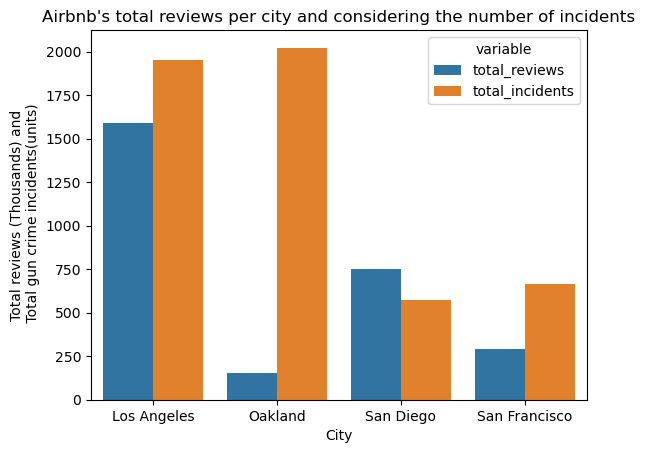

In [95]:
# Plot the number of reviews, color by the number of incidents or reviews, all gruped by city
fig = sns.barplot(data=new_df, x=new_df.index, y='value',hue='variable', palette=sns.color_palette("tab10"))
fig.set(xlabel='City', ylabel='Total reviews (Thousands) and\n Total gun crime incidents(units)', title="Airbnb's total reviews per city and considering the number of incidents")
plt.show()

Conclusions:
+ Los Angeles has a high number of reviews and a high number of gun crimes incidents.
+ Compared to Los Angeles, San Diego and San Francisco have considerably less reviews but also considerably less crimes.
+ Oakland; however, has less airbnb reviews than the previous three, but even more gun crimes that the big city of Los Angeles.
+ **Final conclusion:** There is almost no correlation between the number of gun crimes and the number of reviews in airbnbs of California.

### How many Airbnbs by type exist on average within a 1 kilometer radius of fatal gun crime incidents?

In [96]:
# Select only the incidents with persons being killed
kill_crimes= gun_crimes_geocoded[gun_crimes_geocoded['n_killed']>=1].copy()
kill_crimes

,incident_id,date,state,city,address,n_killed,n_injured,full_addre,geometry
4,2314483,2022-05-28,California,Carmichael,4400 block of Manzanita Ave,1,0,"4400 block of Manzanita Ave, Carmichael, Calif...",POINT (17486.470 4231995.076)
8,2314468,2022-05-28,South Carolina,Charleston,2363 Ashley River Rd,2,0,"2363 Ashley River Rd, Charleston, South Caroli...",POINT (4058202.122 4309298.682)
9,2314321,2022-05-28,Georgia,Thomaston,205 Park Ln,1,2,"205 Park Ln, Thomaston, Georgia, United States",POINT (3532247.635 4269015.223)
13,2314518,2022-05-28,Missouri,Ozark,100 block of W Church St,1,0,"100 block of W Church St, Ozark, Missouri, Uni...",POINT (2632397.845 4372786.288)
14,2314395,2022-05-28,Connecticut,Bridgeport,40 Knoll Pl,1,0,"40 Knoll Pl, Bridgeport, Connecticut, United S...",POINT (4188832.396 5593799.169)
...,...,...,...,...,...,...,...,...,...
308484,478948,2013-01-07,Oklahoma,Tulsa,6000 block of South Owasso,4,0,"6000 block of South Owasso, Tulsa, Oklahoma, U...",POINT (2404148.651 4209744.326)
308485,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,"307 Mourning Dove Terrace, Greensboro, North C...",POINT (3894097.068 4700823.212)
308486,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,"16000 block of East Ithaca Place, Aurora, Colo...",POINT (1543480.829 4470845.187)
308487,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,"1776 East 28th Street, Lorain, Ohio, United St...",POINT (3424744.127 5218853.497)


In [97]:
# Create the buffer of 1km arround each incident with killed people
kill_crimes_buffer = kill_crimes.buffer(1000).to_crs(32611)

# Intersect the buffer with airbnbs
airbnbs_within_buffer = gpd.overlay(airbnb, gpd.GeoDataFrame(geometry=kill_crimes_buffer, crs=32611), how='intersection')

# Remove the airbnbs that were counted more than once because they're near more than one crime scene
airbnbs_within_buffer.drop_duplicates(subset='room_id', keep='first', inplace=True)

# Group by room_type and calculate the count for each type
room_type_counts = airbnbs_within_buffer.groupby('room_type').size().sort_values(ascending=False)

# Print or visualize the results
print("Number of Airbnb listings in different room types, near a crime with kills:\n", room_type_counts)

Number of Airbnb listings in different room types, near a crime with kills:
 room_type
Entire home/apt    134903
Private room        42519
Shared room          1192
Hotel room            885
dtype: int64


In [98]:
airbnb[['room_type']].value_counts()

room_type      
Entire home/apt    201692
Private room        57955
Shared room          1466
Hotel room           1091
Name: count, dtype: int64

In [99]:
airbnb['room_type'].value_counts()/room_type_counts

room_type
Entire home/apt    1.495089
Private room       1.363038
Shared room        1.229866
Hotel room         1.232768
dtype: float64

Conclusions:
+ There are more Entire home/apt type of Airbnb in 1km from places were people got killed, and less from Hotel room type.
+ Nevertheless, those numbers aren’t very confident because we are having more Airbnb near killed incidents from the types that more common, and less from the type that are less common (the proportion of total type of Airbnb with type of Airbnb near killed incidents is the same).


### Is there a relationship between the Rating in TripAdvisor of a museum and the number of Airbnb places to stay within a radius of 10 km? and with the number of reviews (hence the number of stays)?

To solve that question we need to import the dataset of Museums, it is composed of different tables, but we only will use data regarding the Rating of the museum, and that information is in the Museum table.\
\
Note:
+ We won’t use the other datasets because they aren’t relevant to our analysis.
+ We won’t use the Traveler Rating dataset because the information there is redundant to the one in the Rating variable (Rating is the mean of the Traveler Rating).


In [100]:
# Import
museum = pd.read_excel('museum_data.xlsx')
print(len(museum))
# See the dataset
museum.head()

1014


,Museum_id,Address,Description,FeatureCount,Fee,MuseumName,PhoneNum,Rank,Rating,ReviewCount,TotalThingsToDo
0,635,"555 Pennsylvania Ave NW, Washington DC, DC 200...",Find out for yourself why everyone is calling ...,3,Yes,Newseum,+1 888-639-7386,8,4.5,"6,309",398
1,883,"1000 5th Ave, New York City, NY 10028-0198",At New York City's most visited museum and att...,12,Yes,The Metropolitan Museum of Art,1 212-535-7710,2,5.0,"36,627","1,028"
2,901,"945 Magazine Street, New Orleans, LA 70130-3813","Founded by historian and author, Stephen Ambro...",11,No,The National WWII Museum,+1 504-528-1944,1,5.0,"15,611",319
3,202,"2001 N Colorado Blvd, Denver, CO 80205-5798",The Denver Museum of Nature & Science is the R...,0,No,Denver Museum of Nature & Science,303-370-6000,4,4.5,"2,564",231
4,50,"111 S Michigan Ave, Chicago, IL 60603-6488","This Classical Renaissance structure, guarded ...",5,Yes,Art Institute of Chicago,312 443 3600,1,5.0,"15,532",614


In [101]:
# Drop duplicates
to_drop = museum[museum.duplicated(subset = ['Museum_id'], keep = False)] # Different addresses
museum.drop(to_drop.index, inplace = True)
len(museum)

1002

In [102]:
museum.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1002 entries, 0 to 1013
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Museum_id        1002 non-null   int64  
 1   Address          1002 non-null   object 
 2   Description      1002 non-null   object 
 3   FeatureCount     1002 non-null   int64  
 4   Fee              1002 non-null   object 
 5   MuseumName       1002 non-null   object 
 6   PhoneNum         1000 non-null   object 
 7   Rank             1002 non-null   int64  
 8   Rating           1002 non-null   float64
 9   ReviewCount      1002 non-null   object 
 10  TotalThingsToDo  1002 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 93.9+ KB


In [103]:
# Drop this column because had duplicates and is not useful and has missing values
museum.drop('PhoneNum', inplace = True, axis =1)

#### Geocoding

To use this dataset we need to transform it to a geographical dataset to see how far or close were our Airbnbs to the museums.

In [104]:
# Do the geocode (takes 10min)
museum_geo = gpd.tools.geocode(museum['Address'], timeout=6)
museum_geo

,geometry,address
0,POINT (-77.01924 38.90176),"555 Mass Ave, 555, Massachusetts Avenue Northw..."
1,POINT (-73.96338 40.77944),"The Metropolitan Museum of Art, 1000, 5th Aven..."
2,POINT (-90.07077 29.94214),"The National World War II Museum, 945, Magazin..."
3,POINT (-104.94291 39.74755),"Denver Museum of Nature and Science, 2001, Col..."
4,POINT (-87.62308 41.87960),"The Art Institute of Chicago, 111, South Michi..."
...,...,...
1009,POINT (-85.82025 33.69658),"Anniston Museum of Natural History, Museum Dri..."
1010,POINT (-104.23417 34.46811),"East Sumner Avenue, 88119, Fort Sumner, New Me..."
1011,POINT (-70.04481 41.29117),"Nantucket Shipwreck & Lifesaving Museum, 158, ..."
1012,POINT (-118.39509 34.02587),"Museum of Jurassic Technology, 9341, Venice Bo..."


In [105]:
# Merge the two DataFrames based on the index
museum_with_geo = pd.merge(museum, museum_geo, left_index=True, right_index=True)
museum_with_geo.drop('Address', axis=1,inplace=True)
museum_with_geo.head()

,Museum_id,Description,FeatureCount,Fee,MuseumName,Rank,Rating,ReviewCount,TotalThingsToDo,geometry,address
0,635,Find out for yourself why everyone is calling ...,3,Yes,Newseum,8,4.5,"6,309",398,POINT (-77.01924 38.90176),"555 Mass Ave, 555, Massachusetts Avenue Northw..."
1,883,At New York City's most visited museum and att...,12,Yes,The Metropolitan Museum of Art,2,5.0,"36,627","1,028",POINT (-73.96338 40.77944),"The Metropolitan Museum of Art, 1000, 5th Aven..."
2,901,"Founded by historian and author, Stephen Ambro...",11,No,The National WWII Museum,1,5.0,"15,611",319,POINT (-90.07077 29.94214),"The National World War II Museum, 945, Magazin..."
3,202,The Denver Museum of Nature & Science is the R...,0,No,Denver Museum of Nature & Science,4,4.5,"2,564",231,POINT (-104.94291 39.74755),"Denver Museum of Nature and Science, 2001, Col..."
4,50,"This Classical Renaissance structure, guarded ...",5,Yes,Art Institute of Chicago,1,5.0,"15,532",614,POINT (-87.62308 41.87960),"The Art Institute of Chicago, 111, South Michi..."


In [106]:
# Convert the merged DataFrame to a GeoDataFrame
museum_with_geo = gpd.GeoDataFrame(museum_with_geo, geometry='geometry')
# See if the geocode was made in all of our museums
len(museum_with_geo[museum_with_geo['address'].isnull()])

137

In [107]:
# Removing all observations were the geocode is null
museum_with_geo.dropna(inplace=True)

In [108]:
# See the crs
museum_with_geo.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [109]:
# Covert to the crs of the Airbnb dataset
museum_with_geo.to_crs(crs = '32611', inplace = True)

In [110]:
# Testing the geocoding
museum_with_geo[museum_with_geo['address'].notnull()].explore()

Now we can solve the question: 'Is there a relationship between the Rating in TripAdvisor of a museum and the number of Airbnb places to stay within a radius of 10 km? and with the number of reviews (hence the number of stays)?'

We will start seeing the relationship of Rating in TripAdvisor of a museum and the number of Airbnbs.

In [111]:
# Apply the function to each row in the 'museum' GeoDataFrame
# Function: 1)Add a buffer of 10km to each museum
#           2)Count the number of Airbnb points within the buffer of 10km for each museum
museum_with_geo['Airbnbs_Count'] = museum_with_geo.apply(lambda row: airbnb[['geometry']].within(row['geometry'].buffer(10000)).sum(), axis=1)
museum_with_geo.head()


,Museum_id,Description,FeatureCount,Fee,MuseumName,Rank,Rating,ReviewCount,TotalThingsToDo,geometry,address,Airbnbs_Count
0,635,Find out for yourself why everyone is calling ...,3,Yes,Newseum,8,4.5,"6,309",398,POINT (4007428.254 5151124.045),"555 Mass Ave, 555, Massachusetts Avenue Northw...",5917
1,883,At New York City's most visited museum and att...,12,Yes,The Metropolitan Museum of Art,2,5.0,"36,627","1,028",POINT (4151969.011 5511619.974),"The Metropolitan Museum of Art, 1000, 5th Aven...",21439
2,901,"Founded by historian and author, Stephen Ambro...",11,No,The National WWII Museum,1,5.0,"15,611",319,POINT (3146399.292 3638080.737),"The National World War II Museum, 945, Magazin...",6691
3,202,The Denver Museum of Nature & Science is the R...,0,No,Denver Museum of Nature & Science,4,4.5,"2,564",231,POINT (1534335.027 4469894.648),"Denver Museum of Nature and Science, 2001, Col...",4755
4,50,"This Classical Renaissance structure, guarded ...",5,Yes,Art Institute of Chicago,1,5.0,"15,532",614,POINT (2945151.312 5075301.927),"The Art Institute of Chicago, 111, South Michi...",4966


In [112]:
#getting the statistics of the column that tells us the number of airbnbs ithin a radius of 10 km for each museum
museum_with_geo['Airbnbs_Count'].describe()

count      865.000000
mean      1724.852023
std       4530.311598
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      27397.000000
Name: Airbnbs_Count, dtype: float64

In [113]:
len(museum_with_geo[museum_with_geo['Airbnbs_Count'] == 0])

652

In [114]:
museum_with_geo['Rating'].value_counts()

Rating
4.5    623
4.0    131
5.0     90
3.5     19
3.0      1
2.5      1
Name: count, dtype: int64

Correlation using the dataset: -0.12580686768067897
Correlation using agregation: -0.4285714285714286 


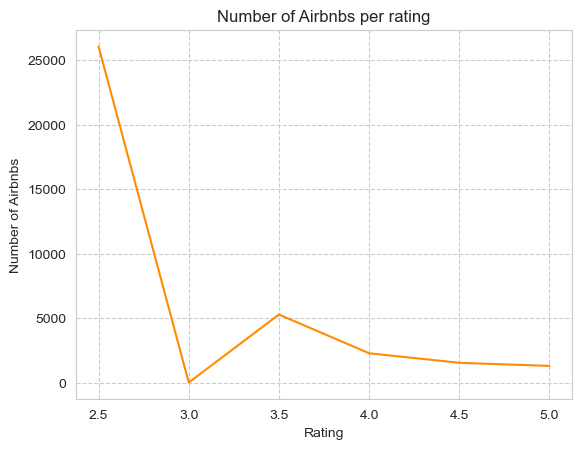

In [115]:
# Correlation of Rating with Airbnbs_Count
print(f"Correlation using the dataset: {museum_with_geo['Rating'].corr(museum_with_geo['Airbnbs_Count'], method='spearman')}")

agregated = museum_with_geo[['Rating','Airbnbs_Count']].groupby('Rating').mean().reset_index()
# Correlation of Rating with Airbnbs_Count
print(f"Correlation using agregation: {agregated['Rating'].corr(agregated['Airbnbs_Count'], method='spearman')} ")

sns.set_style("whitegrid", {'grid.linestyle': '--'})
# Plot the relationship between the Rating of a museum and the number of airbnbs nearby
fig = sns.lineplot(data=museum_with_geo, x='Rating', y='Airbnbs_Count', errorbar=None, color='darkorange')
fig.set(xlabel='Rating', ylabel='Number of Airbnbs', title='Number of Airbnbs per rating')
fig.set_xticks([2.5,3,3.5,4,4.5,5])
plt.show()

Correlation using the dataset: -0.12254625742945674
Correlation using agregation: -1.0


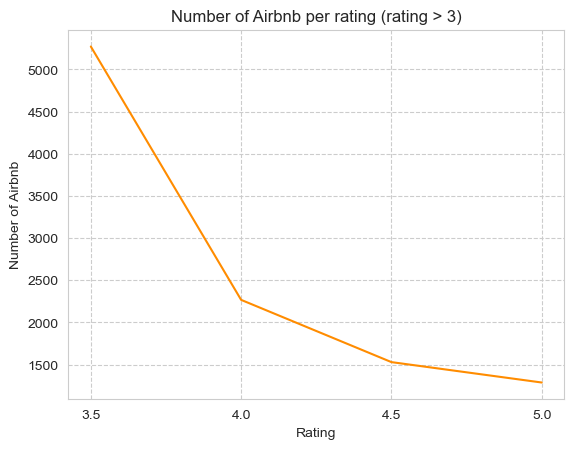

In [116]:
museumns_big_rating = museum_with_geo[museum_with_geo['Rating'] >3]

# Correlation of Rating with Airbnbs_Count
print(f"Correlation using the dataset: {museumns_big_rating['Rating'].corr(museumns_big_rating['Airbnbs_Count'], method='spearman')}")

agregated = museumns_big_rating[['Rating','Airbnbs_Count']].groupby('Rating').mean().reset_index()
# Correlation of Rating with Airbnbs_Count
print(f"Correlation using agregation: {agregated['Rating'].corr(agregated['Airbnbs_Count'], method='spearman')}")

# Plot the relationship between the Rating of a museum and the number of airbnbs nearby
fig = sns.lineplot(data=museumns_big_rating, x='Rating', y='Airbnbs_Count', errorbar=None, color='darkorange')
fig.set(xlabel='Rating', ylabel='Number of Airbnb', title='Number of Airbnb per rating (rating > 3)')
fig.set_xticks([3.5,4,4.5,5])
plt.show()

Correlation using the dataset: -0.10227923393255492
Correlation using agregation: -0.19999999999999998


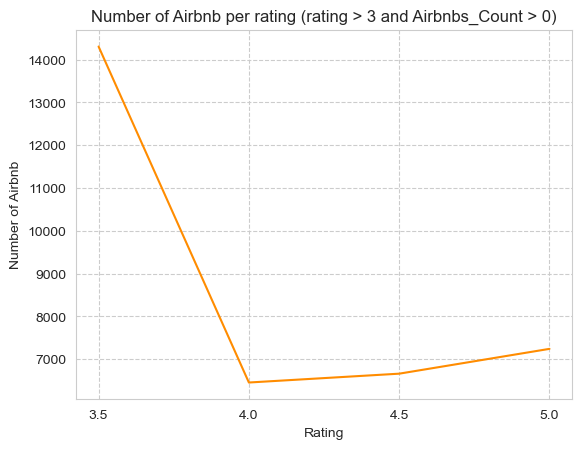

In [117]:
museumns_with_airbnb = museumns_big_rating[museumns_big_rating['Airbnbs_Count'] > 0]

# Correlation of Rating with Airbnbs_Count
print(f"Correlation using the dataset: {museumns_with_airbnb['Rating'].corr(museumns_with_airbnb['Airbnbs_Count'], method='spearman')}")

agregated = museumns_with_airbnb[['Rating','Airbnbs_Count']].groupby('Rating').mean().reset_index()
# Correlation of Rating with Airbnbs_Count
print(f"Correlation using agregation: {agregated['Rating'].corr(agregated['Airbnbs_Count'], method='spearman')}")

# Plot the relationship between the Rating of a museum and the number of airbnbs nearby
fig = sns.lineplot(data=museumns_with_airbnb, x='Rating', y='Airbnbs_Count', errorbar=None, color='darkorange')
fig.set(xlabel='Rating', ylabel='Number of Airbnb', title='Number of Airbnb per rating (rating > 3 and Airbnbs_Count > 0)')
fig.set_xticks([3.5,4,4.5,5])
plt.show()

Conclusions:
+ The museums with the worst ratings, in general, have a lot of airbnbs nearby. On the other hand, 4+ rating museums have much less airbnbs nearby.
+ This could be due to the fact that the most popular museums are in more centered and more expensive areas, where there will be inevitably less airbnbs.
+ The majority of Museums (653) don’t have Airbnb in a range of 10km.
+ It is important to note that we only have 1 museum with rating of 2.5 and 1 with rating of 3, so the calculation of the number of Airbnbs is relative to only 1 museum, in contrast with the other ratings that have more than 1 museum, with the final result being the mean of the computations.
+ If we consider only the museums with rating above 3 (rating that will contain more than 1 museum per rating) we see that there is a perfect negative correlation, meaning that the higher the rating the lower the number of Airbnb within 10km of the museum.
+ If we consider museums with rating above 3 and museums that in the proximities have at least 1 Airbnb; we see that museums with rating 3.5 have a lot of Airbnbs, then the number of Airbnbs close to the museum drops for the museums of rating of 4 and then the number of Airbnbs starts going up as the rating goes to 5 .

Note: We have 2 correlations printed because the first is using each row of the dataset, the second print is the correlation after grouping by rating and calculating the mean.


Now we will see if exists any correlation between the number of reviews regarding the rating that travelers make

In [118]:
# Apply the function to each row in the 'museum' GeoDataFrame
# Function: 1)Add a buffer of 10km to each museum
#           2)Count the number of reviews of Airbnb within the buffer of 10km for each museum
museum_with_geo['review_Count'] = museum_with_geo.apply(lambda row: airbnb[airbnb[['geometry']].within(row['geometry'].buffer(10000))]['total_reviews'].sum(), axis=1)

Correlation using the dataset: -0.12512905370404678
Correlation using agregation: -0.4285714285714286 


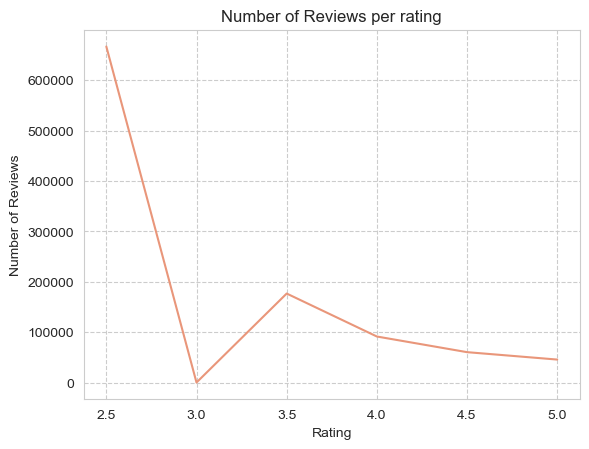

In [119]:
# Correlation of Rating with review_Count
print(f"Correlation using the dataset: {museum_with_geo['Rating'].corr(museum_with_geo['review_Count'], method='spearman')}")

agregated = museum_with_geo[['Rating','review_Count']].groupby('Rating').mean().reset_index()
# Correlation of Rating with review_Count
print(f"Correlation using agregation: {agregated['Rating'].corr(agregated['review_Count'], method='spearman')} ")

# Plot the relationship between the Rating of a museum and the number of airbnbs nearby
fig = sns.lineplot(data=museum_with_geo, x='Rating', y='review_Count', errorbar=None, color = 'darksalmon')
fig.set(xlabel='Rating', ylabel='Number of Reviews', title='Number of Reviews per rating')
fig.set_xticks([2.5,3,3.5,4,4.5,5])
plt.show()

Correlation using the dataset: -0.12186166816601063
Correlation using agregation: -1.0


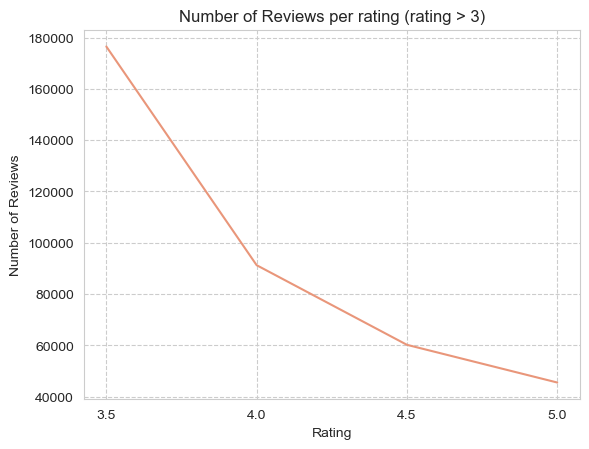

In [120]:
museumns_big_rating = museum_with_geo[museum_with_geo['Rating'] >3]

# Correlation of Rating with review_Count
print(f"Correlation using the dataset: {museumns_big_rating['Rating'].corr(museumns_big_rating['review_Count'], method='spearman')}")

agregated = museumns_big_rating[['Rating','review_Count']].groupby('Rating').mean().reset_index()
# Correlation of Rating with review_Count
print(f"Correlation using agregation: {agregated['Rating'].corr(agregated['review_Count'], method='spearman')}")

# Plot the relationship between the Rating of a museum and the number of review_Count
fig = sns.lineplot(data=museumns_big_rating, x='Rating', y='review_Count', errorbar=None,  color = 'darksalmon')
fig.set(xlabel='Rating', ylabel='Number of Reviews', title='Number of Reviews per rating (rating > 3)')
fig.set_xticks([3.5,4,4.5,5])
plt.show()

Correlation using the dataset: -0.09464462672602642
Correlation using agregation: -0.7999999999999999


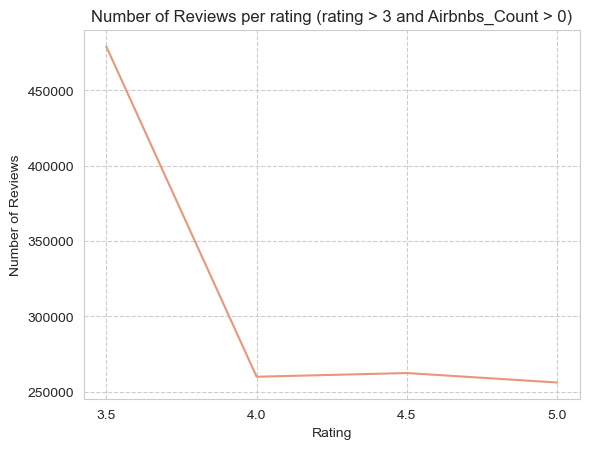

In [121]:
museumns_with_airbnb = museumns_big_rating[museumns_big_rating['Airbnbs_Count'] > 0]

# Correlation of Rating with Airbnbs_Count
print(f"Correlation using the dataset: {museumns_with_airbnb['Rating'].corr(museumns_with_airbnb['review_Count'], method='spearman')}")

agregated = museumns_with_airbnb[['Rating','review_Count']].groupby('Rating').mean().reset_index()
# Correlation of Rating with review_Count
print(f"Correlation using agregation: {agregated['Rating'].corr(agregated['review_Count'], method='spearman')}")

# Plot the relationship between the Rating of a museum and the number of review_Count
fig = sns.lineplot(data=museumns_with_airbnb, x='Rating', y='review_Count', errorbar=None, color = 'darksalmon')
fig.set(xlabel='Rating', ylabel='Number of Reviews', title='Number of Reviews per rating (rating > 3 and Airbnbs_Count > 0)')
fig.set_xticks([3.5,4,4.5,5])
plt.show()

In [122]:
print(museumns_with_airbnb['Airbnbs_Count'].corr(museumns_with_airbnb['review_Count'], method='spearman'))

0.9139628596652157


Conclusions:
+ It's important to mention that we only have 1 museum with rating of 2.5 and 1 with rating of 3, so the calculation of the number of Airbnb is relative to only 1 museum, in comparison with the other ratings that have more than 1 museum, with the final result being the mean of the computations.
+ If we consider all museums, we see that the museums with the worst ratings, in general, have a lot of Airbnb reviews nearby. On the other hand, 4+ rating museums have much less airbnbs with reviews nearby.
+ This could be because the most popular museums are in more centered and more expensive areas, where there will be inevitably less airbnbs.
+ If we consider only the museums with rating above 3 (rating that will contain more than 1 museum per rating) we see that there is a perfect negative correlation, meaning that the higher the rating the lower the number of reviews of Airbnb within 10km of the museum.
+ If we consider museums with rating above 3 and museums that in the proximities have at least 1 Airbnb; we see that museums with rating 3.5 have a lot of Airbnb reviews, then the number of Airbnb reviews close to the museum drops for the museums of rating of 4 and them the number of Airbnb reviews stays almost constant as the rating goes to 5.
+ The conclusions are very similar compared with the analysis of the number of Airbnbs because there is a strong correlation between the number of Airbnbs nearby museums and the number of Airbnb reviews near the museums.

Note: We have 2 correlations print because the first is using each row of the dataset, the second print is the correlation after grouping by rating and calculating the mean.

### Is there any relationship between the population of a state and the the amount of airbnb listings in that state?

To solve that question we need to import the dataset that contains the population of the different states.\
\
Since we don’t know the year of the information regarding the Airbnb dataset, we will use a dataset from the year 2014 because it is relatively recent, was the easier to find and also because the population normally grows slowly and in line with the previous values (larger populations grow more than small populations from year to year).

In [123]:
# Importing the dataset
# This dataset contains the total population, in 2014, for each state of the USA
populations= pd.read_csv('us-state-populations.csv')
populations

,code,state,pop_2014
0,AL,Alabama,4849377
1,AK,Alaska,736732
2,AZ,Arizona,6731484
3,AR,Arkansas,2966369
4,CA,California,38802500
5,CO,Colorado,5355866
6,CT,Connecticut,3596677
7,DE,Delaware,935614
8,DC,District of Columbia,658893
9,FL,Florida,19893297


In [124]:
# Drop redundant column
populations.drop('code', axis=1, inplace=True)
# Set 'state' as index
populations.set_index('state', drop=True, inplace=True)
populations

,pop_2014
state,
Alabama,4849377
Alaska,736732
Arizona,6731484
Arkansas,2966369
California,38802500
Colorado,5355866
Connecticut,3596677
Delaware,935614
District of Columbia,658893


In [125]:
#Group the airbnbs by state and get the total number of Airbnb for each state
nr_airbnbs_per_state= pd.DataFrame(airbnb.groupby('state')['room_id'].count())
nr_airbnbs_per_state.rename(columns={'room_id':'Number of Airbnbs'}, inplace=True)
nr_airbnbs_per_state

,Number of Airbnbs
state,
California,76749
Colorado,5684
District of Columbia,6286
Florida,16366
Hawaii,28487
Illinois,7155
Louisiana,6838
Massachusetts,2906
Minnesota,3957


In [126]:
# Merge on the 'state' index
population_and_rooms_p_state = pd.merge(populations, nr_airbnbs_per_state, left_index=True, right_index=True, how='inner')
population_and_rooms_p_state['pop_2014_M'] = population_and_rooms_p_state['pop_2014']/1000000
population_and_rooms_p_state['Number of Airbnbs (Hundreds)'] = population_and_rooms_p_state['Number of Airbnbs']/1000
population_and_rooms_p_state


,pop_2014,Number of Airbnbs,pop_2014_M,Number of Airbnbs (Hundreds)
state,,,,
California,38802500,76749,38.802500,76.749
Colorado,5355866,5684,5.355866,5.684
District of Columbia,658893,6286,0.658893,6.286
Florida,19893297,16366,19.893297,16.366
Hawaii,1419561,28487,1.419561,28.487
Illinois,12880580,7155,12.880580,7.155
Louisiana,4649676,6838,4.649676,6.838
Massachusetts,6745408,2906,6.745408,2.906
Minnesota,5457173,3957,5.457173,3.957


Now we can solve the question: 'Is there any relationship between the population of a state and the the amount of airbnb listings in that state?'

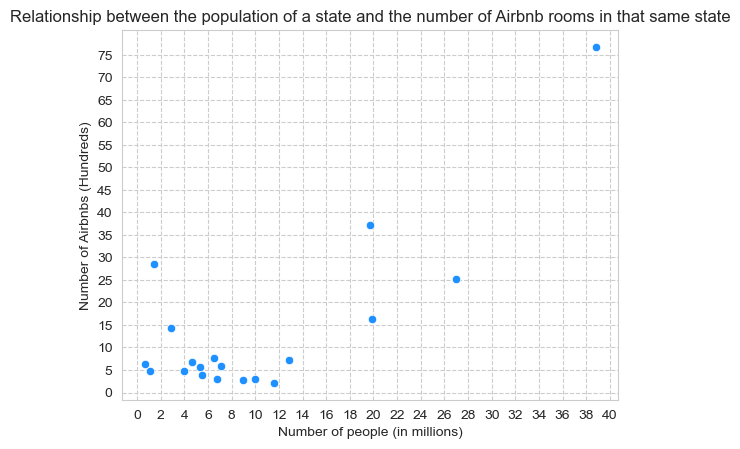

In [127]:
#Plotting a line, having the population per state in the x axis and the number of Airbnb per state in the y axis
fig = sns.scatterplot(data=population_and_rooms_p_state, x='pop_2014_M', y='Number of Airbnbs (Hundreds)', color='dodgerblue')
fig.set(xlabel='Number of people (in millions)', ylabel='Number of Airbnbs (Hundreds)', title='Relationship between the population of a state and the number of Airbnb rooms in that same state')
fig.set_xticks(range(0,41,2))
fig.set_yticks(range(0,80,5))
plt.show()

In [128]:
#Correlation of population with Number of Airbnbs
print(population_and_rooms_p_state['pop_2014'].corr(population_and_rooms_p_state['Number of Airbnbs'], method='spearman'))

0.22982456140350876


Conclusions:
+ Althogh it is not a perfect positive correlation, we can see that, in general, the higher the state's population, the greater the amount of airbnbs listings in that state.

# IV. Conclusion


Airbnb's dataset analysis reveals crucial insights for strategic decision-making. Here we have a summary of all of our work:
+ The pricing spectrum, ranging from 40 dollars to $100,000 per night, showcases the variety of options, with Ohio as the most budget-friendly and Hawaii as the most expensive state.
+ California, particularly Los Angeles, dominates with the highest number of listings Airbnb and hosts.
+ The top 3000 hosts, primarily offering 'Entire home/apt' rooms, contribute significantly to Airbnb's profits, with preferences leaning towards California and Los Angeles.
+ For USS Midway visitors, the closest private room is just 532 meters away, amongst a high density of accommodations within a 100km radius.
+ Surprisingly, no clear correlation emerged between gun crimes and Airbnb reviews.
+ Higher-rated museums tend to have fewer nearby Airbnb listings, likely influenced by their locations in more expensive areas.
+ States with larger populations generally host more Airbnb listings.

Despite providing valuable insights, our analysis encounters several limitations; such as:
+ The dataset covers 1575 neighbourhoods in 19 states, potentially limiting geographical diversity.
+ Lack of ‘stay’ information led us to use reviews as an approximation for popularity, assuming all guests leave reviews, which is not accurate and doesn’t say for how long they stayed.
+ Duplicated room IDs in different cities were excluded, potentially omitting valid observations (or being an error in the data collection).
+ Limited number of cities, except in California, may impact regional variations.  
+ We don’t know when the data was obtained, so we don’t know if the cross analysis that we did with the different datasets is extremely accurate and relevant since we use incidents corresponding to many years and population of the year 2014.

These limitations underscore the need for careful interpretation and suggest possible future improvements in data collection (for the duplicates observations and no specification of the year/time of the data).

Finaly we have some recommendations and suggestions of what could do the people in charge after knowing our work:
+ To boost profitability, Airbnb should target states with lower representation (amount of Airbnb), such as Ohio, and encourage diverse accommodation options to improve the overall user experience, since it has in the vast majority only Entire home or apartment.
+ Recording each night stay would provide structured data on room popularity, complemented by promoting guest reviews for additional credibility.
+ Expanding the dataset geographically is crucial for more comprehensive insights.
+ Collaborating with museums may increase profits and creating Airbnbs near the top-ranked ones and museums with no Airbnb nearby might attract more travelers.
+ Analise in more detail what differentiates the top hosts and what their profits really are to cultivate these behaviors in other hosts, and also keep track of these top hosts to retain them.

These strategic measures aim not only to increase profitability but also to attract a more diverse customer base.


# V. References

US states population dataset- GitHub: https://gist.github.com/bradoyler/0fd473541083cfa9ea6b5da57b08461c

geopandas.GeoSeries.convex_hul- Geopandas documentation: https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.convex_hull.html

pandas.melt- Pandas documentation: https://pandas.pydata.org/docs/reference/api/pandas.melt.html